## Importing the required Libraries

In [195]:
# !pip install kaggle

In [196]:
# !pip install nlpaug

In [197]:
# !pip install torch

In [198]:
# !pip install torchtext

In [199]:
# !pip install unidecode

In [200]:
# !pip install autocorrect

In [201]:
import zipfile as zf
import pandas as pd
import numpy as np
import datetime as dt
import re
import string
import spacy
import tensorflow as tf
import torch

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from scipy.sparse import vstack

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk import pos_tag
from collections import Counter
from gensim.models import Word2Vec

from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, SimpleRNN, Bidirectional
from keras.regularizers import l2
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import unicodedata
from unidecode import unidecode
from autocorrect import Speller
from string import punctuation
from wordcloud import WordCloud, STOPWORDS

import nlpaug.augmenter.word as naw
from nlpaug.util import Action
from transformers import pipeline
import torchtext.utils as utils
import torchtext.vocab as vocab

import warnings
warnings.filterwarnings("ignore")

In [202]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

### **PROBLEM CONTEXT:**
##### The database comes from one of the biggest industry in Brazil and in the world. It is an urgent need for industries/companies around the globe to understand why employees still suffer some injuries/accidents in plants. Sometimes they also die in such environment.

### **DATA DESCRIPTION:**
##### This The database is basically records of accidents from 12 different plants in 03 different countries which every line in the data is an occurrence of an accident.
##### Columns description:
<ul>
    <li>Data: timestamp or time/date information</li>
    <li>Countries: which country the accident occurred (anonymised)</li>
    <li>Local: the city where the manufacturing plant is located (anonymised)</li>
    <li>Industry sector: which sector the plant belongs to</li>
    <li>Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)</li>
    <li>Potential Accident Level: Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors involved in the accident)</li>
    <li>Genre: if the person is male of female</li>
    <li>Employee or Third Party: if the injured person is an employee or a third party</li>
    <li>Critical Risk: some description of the risk involved in the accident</li>
    <li>Description: Detailed description of how the accident happened.</li>
</ul>

### **PROJECT OBJECTIVE**
##### Design a ML/DL based chatbot utility which can help the professionals to highlight the safety risk as per the incident description.

## MILESTONE 1
### Step 1: Import the data

In [203]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [204]:
# folder = 'C:/Users/KS/OneDrive/Documents/DS-AI-ML/Capstone Project/Dataset/'

# with zf.ZipFile('industrial-safety-and-health-analytics-database.zip', 'r') as zip_ref:
#     zip_ref.extractall(folder)

In [205]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone/IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv')
pd.set_option('display.max_colwidth', None)

In [206]:
data.head()

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,"While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo."
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,"During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter."
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,"In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of ​​the left foot of the collaborator causing the injury."
3,3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,"Being 9:45 am. approximately in the Nv. 1880 CX-695 OB7, the personnel begins the task of unlocking the Soquet bolts of the BHB machine, when they were in the penultimate bolt they identified that the hexagonal head was worn, proceeding Mr. Cristóbal - Auxiliary assistant to climb to the platform to exert pressure with your hand on the ""DADO"" key, to prevent it from coming out of the bolt; in those moments two collaborators rotate with the lever in anti-clockwise direction, leaving the key of the bolt, hitting the palm of the left hand, causing the injury."
4,4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,"Approximately at 11:45 a.m. in circumstances that the mechanics Anthony (group leader), Eduardo and Eric Fernández-injured-the three of the Company IMPROMEC, performed the removal of the pulley of the motor of the pump 3015 in the ZAF of Marcy. 27 cm / Length: 33 cm / Weight: 70 kg), as it was locked proceed to heating the pulley to loosen it, it comes out and falls from a distance of 1.06 meters high and hits the instep of the right foot of the worker, causing the injury described."


In [207]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                425 non-null    int64 
 1   Data                      425 non-null    object
 2   Countries                 425 non-null    object
 3   Local                     425 non-null    object
 4   Industry Sector           425 non-null    object
 5   Accident Level            425 non-null    object
 6   Potential Accident Level  425 non-null    object
 7   Genre                     425 non-null    object
 8   Employee or Third Party   425 non-null    object
 9   Critical Risk             425 non-null    object
 10  Description               425 non-null    object
dtypes: int64(1), object(10)
memory usage: 36.6+ KB


In [208]:
data.shape

(425, 11)

### Step 2: Data cleansing

In [209]:
data.isna().sum()

Unnamed: 0                  0
Data                        0
Countries                   0
Local                       0
Industry Sector             0
Accident Level              0
Potential Accident Level    0
Genre                       0
Employee or Third Party     0
Critical Risk               0
Description                 0
dtype: int64

In [210]:
# Remove the duplicate records in the data

print('There are ', data.shape[0], 'records and ', data.duplicated().sum(), ' duplicates in this dataset.')
data = data.drop_duplicates()
print('There are ', data.shape[0], 'records and ', data.duplicated().sum(), ' duplicates in this dataset.')

There are  425 records and  0  duplicates in this dataset.
There are  425 records and  0  duplicates in this dataset.


In [211]:
# Remove the first 'Unnamed' column
data.drop(data.columns[0], axis=1, inplace=True)

In [212]:
# Renaming the columns appropriately
data.rename(columns={'Data':'Date', 'Countries':'Country', 'Local':'City', 'Genre':'Gender', 'Employee or Third Party':'Employee Type'}, inplace=True)

In [213]:
# Extracting year & month from 'Data' column
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day_name()

In [214]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425 entries, 0 to 424
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      425 non-null    datetime64[ns]
 1   Country                   425 non-null    object        
 2   City                      425 non-null    object        
 3   Industry Sector           425 non-null    object        
 4   Accident Level            425 non-null    object        
 5   Potential Accident Level  425 non-null    object        
 6   Gender                    425 non-null    object        
 7   Employee Type             425 non-null    object        
 8   Critical Risk             425 non-null    object        
 9   Description               425 non-null    object        
 10  Year                      425 non-null    int64         
 11  Month                     425 non-null    int64         
 12  Day                   

In [215]:
data.head()

,Date,Country,City,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee Type,Critical Risk,Description,Year,Month,Day
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,"While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.",2016,1,Friday
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,"During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter.",2016,1,Saturday
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,"In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of ​​the left foot of the collaborator causing the injury.",2016,1,Wednesday
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,"Being 9:45 am. approximately in the Nv. 1880 CX-695 OB7, the personnel begins the task of unlocking the Soquet bolts of the BHB machine, when they were in the penultimate bolt they identified that the hexagonal head was worn, proceeding Mr. Cristóbal - Auxiliary assistant to climb to the platform to exert pressure with your hand on the ""DADO"" key, to prevent it from coming out of the bolt; in those moments two collaborators rotate with the lever in anti-clockwise direction, leaving the key of the bolt, hitting the palm of the left hand, causing the injury.",2016,1,Friday
4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,"Approximately at 11:45 a.m. in circumstances that the mechanics Anthony (group leader), Eduardo and Eric Fernández-injured-the three of the Company IMPROMEC, performed the removal of the pulley of the motor of the pump 3015 in the ZAF of Marcy. 27 cm / Length: 33 cm / Weight: 70 kg), as it was locked proceed to heating the pulley to loosen it, it comes out and falls from a distance of 1.06 meters high and hits the instep of the right foot of the worker, causing the injury described.",2016,1,Sunday


In [216]:
# Checking the unique values of each column
col_ls = data.columns[:data.shape[1]-1]

for col in col_ls:
    print("\n", col, ":")
    print(data[col].unique())


 Date :
['2016-01-01T00:00:00.000000000' '2016-01-02T00:00:00.000000000'
 '2016-01-06T00:00:00.000000000' '2016-01-08T00:00:00.000000000'
 '2016-01-10T00:00:00.000000000' '2016-01-12T00:00:00.000000000'
 '2016-01-16T00:00:00.000000000' '2016-01-17T00:00:00.000000000'
 '2016-01-19T00:00:00.000000000' '2016-01-26T00:00:00.000000000'
 '2016-01-28T00:00:00.000000000' '2016-01-30T00:00:00.000000000'
 '2016-02-01T00:00:00.000000000' '2016-02-02T00:00:00.000000000'
 '2016-02-04T00:00:00.000000000' '2016-02-06T00:00:00.000000000'
 '2016-02-07T00:00:00.000000000' '2016-02-08T00:00:00.000000000'
 '2016-02-21T00:00:00.000000000' '2016-02-25T00:00:00.000000000'
 '2016-02-09T00:00:00.000000000' '2016-02-10T00:00:00.000000000'
 '2016-02-15T00:00:00.000000000' '2016-02-14T00:00:00.000000000'
 '2016-02-13T00:00:00.000000000' '2016-02-16T00:00:00.000000000'
 '2016-02-17T00:00:00.000000000' '2016-02-19T00:00:00.000000000'
 '2016-02-20T00:00:00.000000000' '2016-02-18T00:00:00.000000000'
 '2016-02-22T00:

In [217]:
data[data['Critical Risk']=='\nNot applicable'].head()

,Date,Country,City,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee Type,Critical Risk,Description,Year,Month,Day
154,2016-06-17,Country_02,Local_08,Metals,IV,V,Male,Employee,\nNot applicable,"At approximately 5:45 pm, the operator Paulo (operator of the filters) informed the autoclave operator via radio of a leak on the side of the scruber. The autoclave III feed was stopped by the control and officials Georli and Renato initiated the procedures for closing the autoclave transfer valve for flash TQs. Soon after, there was a break in the chicken, projecting pulp hot and reaching three employees who were inside the room near the equipment.",2016,6,Friday


In [218]:
temp = data
temp['Critical Risk'] = temp['Critical Risk'].str.replace(r'\nNot applicable', 'Not applicable', regex=True)

In [219]:
temp[temp['Critical Risk']=='Not applicable'].head()

,Date,Country,City,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee Type,Critical Risk,Description,Year,Month,Day
154,2016-06-17,Country_02,Local_08,Metals,IV,V,Male,Employee,Not applicable,"At approximately 5:45 pm, the operator Paulo (operator of the filters) informed the autoclave operator via radio of a leak on the side of the scruber. The autoclave III feed was stopped by the control and officials Georli and Renato initiated the procedures for closing the autoclave transfer valve for flash TQs. Soon after, there was a break in the chicken, projecting pulp hot and reaching three employees who were inside the room near the equipment.",2016,6,Friday


In [220]:
col_ls = data.columns[:data.shape[1]-1]

for col in col_ls:
    print("\n\n", col, ":")
    print("----------------------------------------------------------------------------")
    print(data[col].unique())



 Date :
----------------------------------------------------------------------------
['2016-01-01T00:00:00.000000000' '2016-01-02T00:00:00.000000000'
 '2016-01-06T00:00:00.000000000' '2016-01-08T00:00:00.000000000'
 '2016-01-10T00:00:00.000000000' '2016-01-12T00:00:00.000000000'
 '2016-01-16T00:00:00.000000000' '2016-01-17T00:00:00.000000000'
 '2016-01-19T00:00:00.000000000' '2016-01-26T00:00:00.000000000'
 '2016-01-28T00:00:00.000000000' '2016-01-30T00:00:00.000000000'
 '2016-02-01T00:00:00.000000000' '2016-02-02T00:00:00.000000000'
 '2016-02-04T00:00:00.000000000' '2016-02-06T00:00:00.000000000'
 '2016-02-07T00:00:00.000000000' '2016-02-08T00:00:00.000000000'
 '2016-02-21T00:00:00.000000000' '2016-02-25T00:00:00.000000000'
 '2016-02-09T00:00:00.000000000' '2016-02-10T00:00:00.000000000'
 '2016-02-15T00:00:00.000000000' '2016-02-14T00:00:00.000000000'
 '2016-02-13T00:00:00.000000000' '2016-02-16T00:00:00.000000000'
 '2016-02-17T00:00:00.000000000' '2016-02-19T00:00:00.000000000'
 '2

### Exploratory Data Analysis

##### UNIVARIATE ANALYSIS

In [221]:
def plot_uni(df, col, title):
    idx = df[col].value_counts().index
    plt.figure(figsize=(12,10))
    plt.subplot(2, 2, 1)
    plt.pie(df[col].value_counts(), autopct='%.1f', labels=idx, explode=[0.1]*len(idx))
    plt.title(title)
    plt.show()

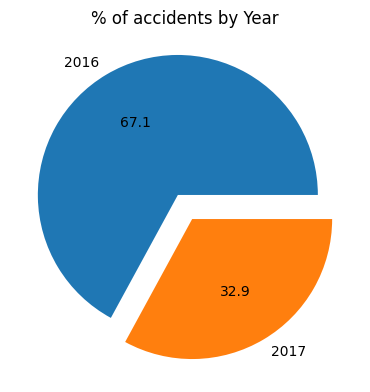

In [222]:
plot_uni(data, 'Year', '% of accidents by Year')

Since the data is available only until 9th July 2017, the numbers above do not provide enough evidence to confirm if accidents increased/ decreased in 2017.

Now, comparing the first half of both years, we can see that the accidents reduced by about 20% in 2017.

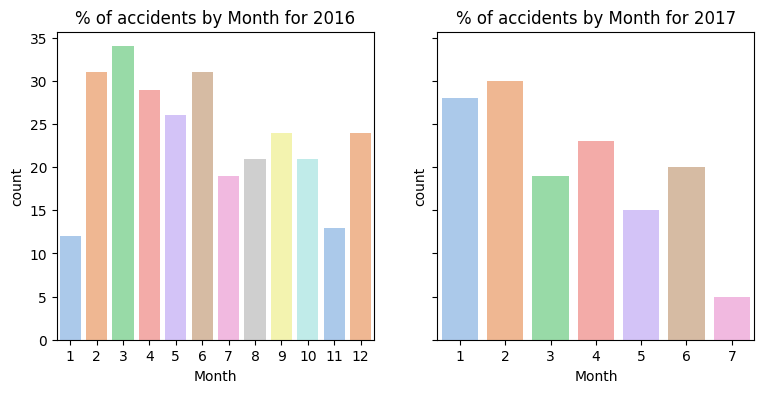

In [223]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
# plt.subplot(1, 2, 2)
sns.countplot(data=data[data['Year']==2016], x='Month', palette='pastel', ax=axes[0])
axes[0].set_title('% of accidents by Month for 2016')
# plt.subplot(2, 2, 2)
sns.countplot(data=data[data['Year']==2017], x='Month', palette='pastel', ax=axes[1])
axes[1].set_title('% of accidents by Month for 2017')
plt.show()

You can see for each month from Feb - Jun, the number of accidents have reduced in 2017.

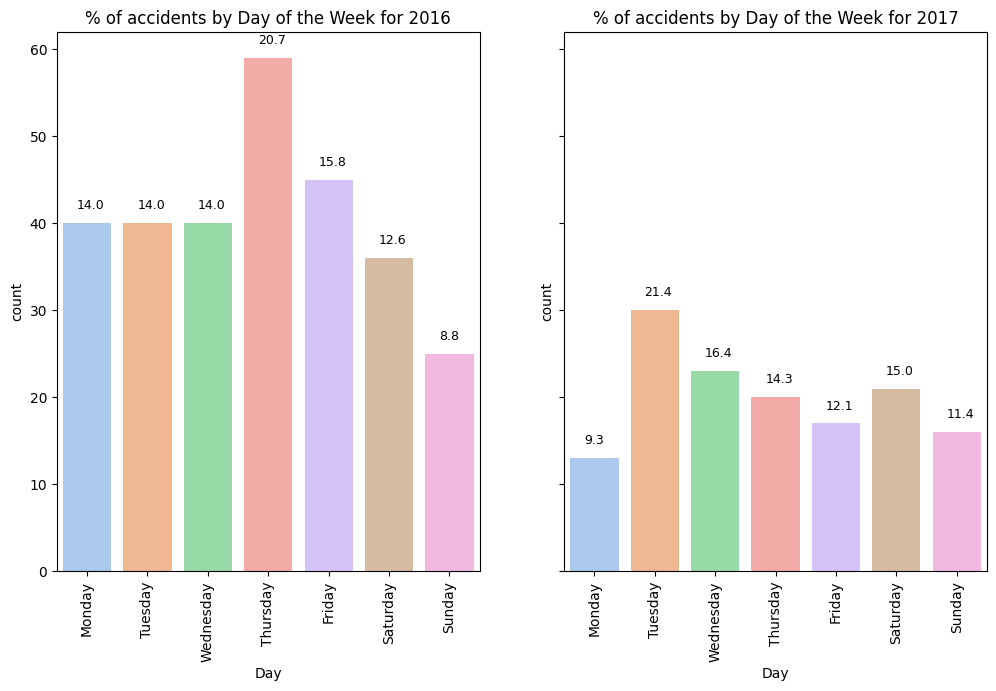

In [224]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharey=True)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data_16 = data[data['Year']==2016]
data_17 = data[data['Year']==2017]

sns.countplot(data=data_16, x='Day', order=day_order, palette='pastel', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
total = sum(data_16['Day'].value_counts())
for p in axes[0].patches:
    axes[0].annotate('{:.1f}'.format(100 * p.get_height() / total),
                (p.get_x(), p.get_height()), size=9, xytext=(10, 10), textcoords='offset points')
axes[0].set_title('% of accidents by Day of the Week for 2016')

sns.countplot(data=data_17, x='Day', order=day_order, palette='pastel', ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
total = sum(data_17['Day'].value_counts())
for p in axes[1].patches:
    axes[1].annotate('{:.1f}'.format(100 * p.get_height() / total),
                (p.get_x(), p.get_height()), size=9, xytext=(10, 10), textcoords='offset points')
axes[1].set_title('% of accidents by Day of the Week for 2017')
plt.show()

For Both 2016 & 2017, about 70-80% accidents have happened during the weekdays. People travelling for work on weekdays could be the possible reason for this.

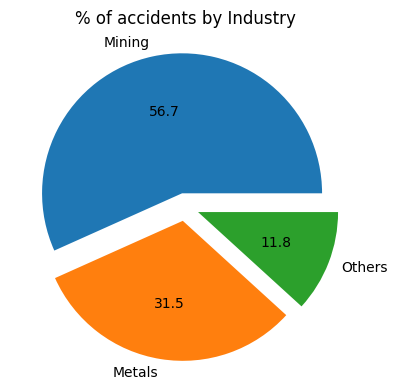

In [225]:
plot_uni(data, 'Industry Sector', '% of accidents by Industry')

Mining industry witnesses the highest number of accidents, followed by Metals industry

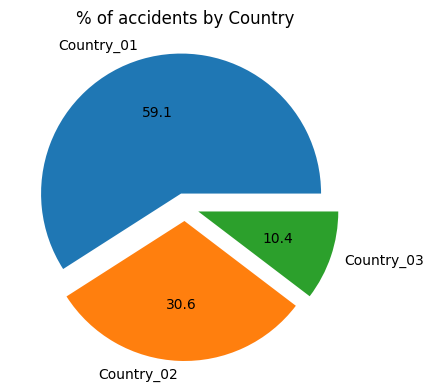

In [226]:
plot_uni(data, 'Country', '% of accidents by Country')

Country_01 witnesses the highest number of accidents, followed by Country02, which together contribute to ~90% of the total accidents.

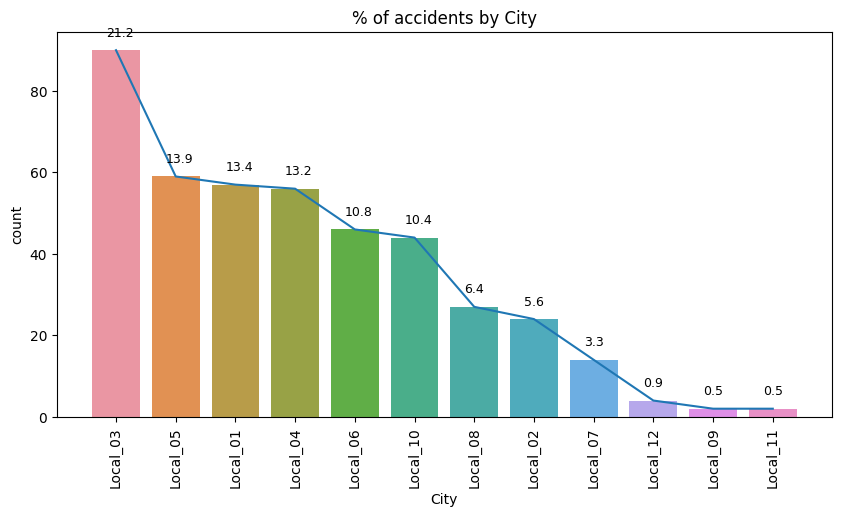

In [227]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data, x='City', order=data['City'].value_counts().index)
sns.lineplot(data['City'].value_counts().values)
plt.xticks(rotation=90)
total = sum(data['City'].value_counts())
for p in ax.patches:
    ax.annotate('{:.1f}'.format(100 * p.get_height() / total),
                (p.get_x(), p.get_height()), size=9, xytext=(10, 10), textcoords='offset points')
plt.title('% of accidents by City')
plt.show()

About 61% of the accidents together occur in plants located in Local_01, Local_03, Local_04 & Local_05 cities, of which Local_03 alone has recorded 21% accidents. Another 21% accidents are recorded by Local_06 & Local_10 cities. The bottom most 6 cities - Local_02, Local_07, Local_08, Local_09, Local_11, Local_12 cities witnessed only 17% of the accidents.

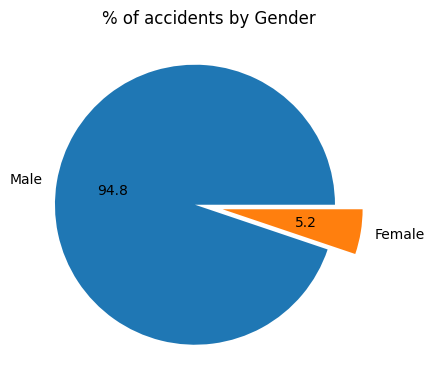

In [228]:
plot_uni(data, 'Gender', '% of accidents by Gender')

We can see the only ~5% Females have encountered accidents. This could be due to a general assumption of majority of industrial jobs being taken up by Males.

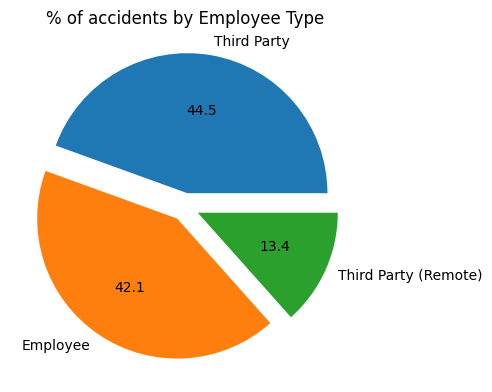

In [229]:
plot_uni(data, 'Employee Type', '% of accidents by Employee Type')

The minimum accidents are faced by the Third Party Remote workers as they are not always working on the sites. Overall 58% of the accidents are encountered Third Party employees.

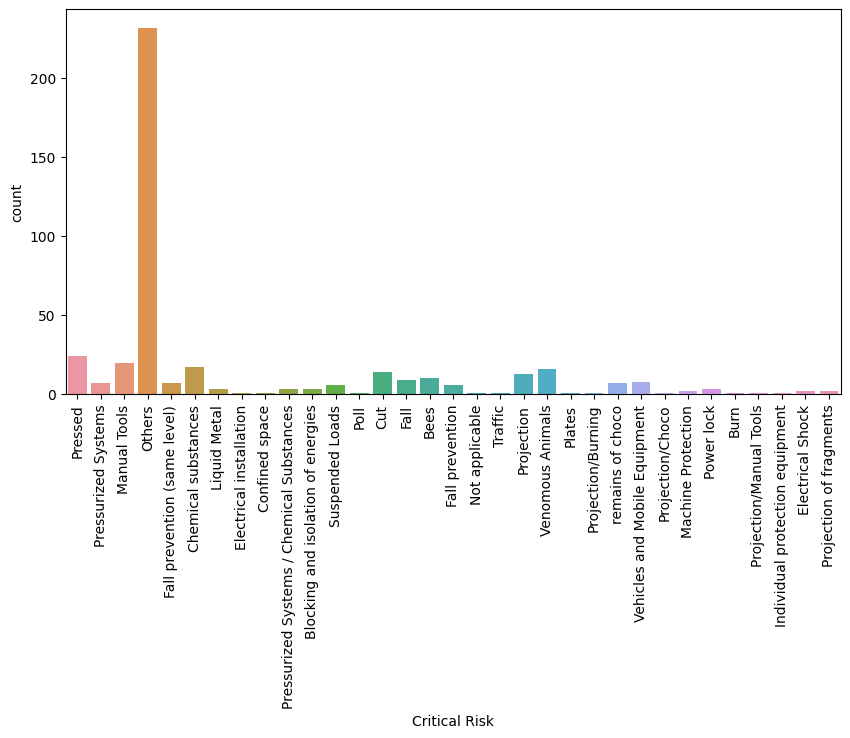

In [230]:
plt.figure(figsize=(10, 5))
sns.countplot(data, x='Critical Risk')
plt.xticks(rotation=90)
plt.show()

Most of the risks are grouped under Others which is about 50% of the dataset. The more common risks observed in the accidents are: Pressed, Manual Tools, Chemical Substances, Venomous Animals, Projection & Cut.

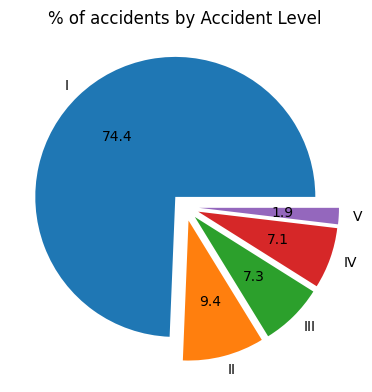

In [231]:
plot_uni(data, 'Accident Level', '% of accidents by Accident Level')

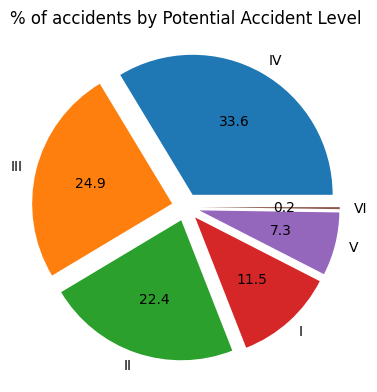

In [232]:
plot_uni(data, 'Potential Accident Level', '% of accidents by Potential Accident Level')

<b>Observations:</b><br/>
<ol>
    <li>Accident Level: Majority of the accidents fall under Level I occuring due to minor misses, while Level II, III & IV have similar frequency of occurence. High risk or severe accidents under Level V are only 2%.</li>
    <li>Potential Accident Level: 81% accidents could potentially be moderately severe onces. and only 7.5% could've potentially been the most severe ones.</li>
    <li>Potential Accident Level differs from the Accident Level. Majority are Level I accidents wheareas potential accidents have a majority in moderately severe ones (Level II, III & IV together).</li>
    <li>Potential Accident Level: It has 6 Accident levels where the Level VI has only 1 accident recorded. To simplify and be able to compare the Accident & Potential Accident Level, we can change this record to the closest level V.</li>
</ol>

In [233]:
# Changing Accident Level VI to closest Level V
data['Potential Accident Level'].replace('VI', 'V', inplace=True)
data[data['Potential Accident Level']=='VI']

,Date,Country,City,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee Type,Critical Risk,Description,Year,Month,Day


##### MULTIVARIATE ANALYSIS

<Axes: title={'center': 'Correlation Matrix of all variables'}>

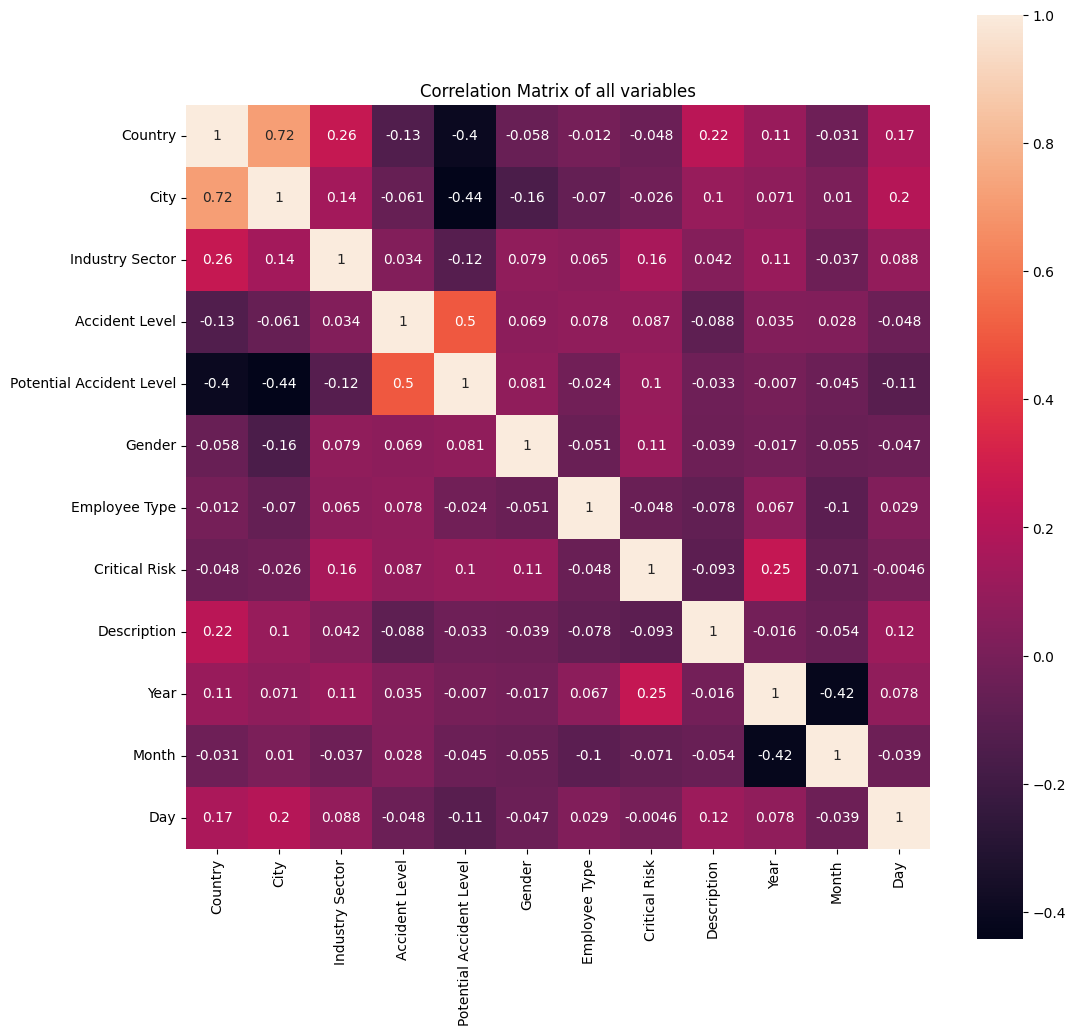

In [234]:
labenc = LabelEncoder()
df = data.iloc[:,1:].apply(labenc.fit_transform)

plt.figure(figsize=(12, 12))
plt.title('Correlation Matrix of all variables')
sns.heatmap(df.corr(), annot=True, square=True)

<b>Observations:</b><br/>
<ol>
    <li>The highest correlation is seen between City & Country, which is also the most obvious expectation.</li>
    <li>Accident Level & Potential Accident Level have only 50% correlation.</li>
    <li>There is only low to moderate correlation among the other variables.</li>
</ol>

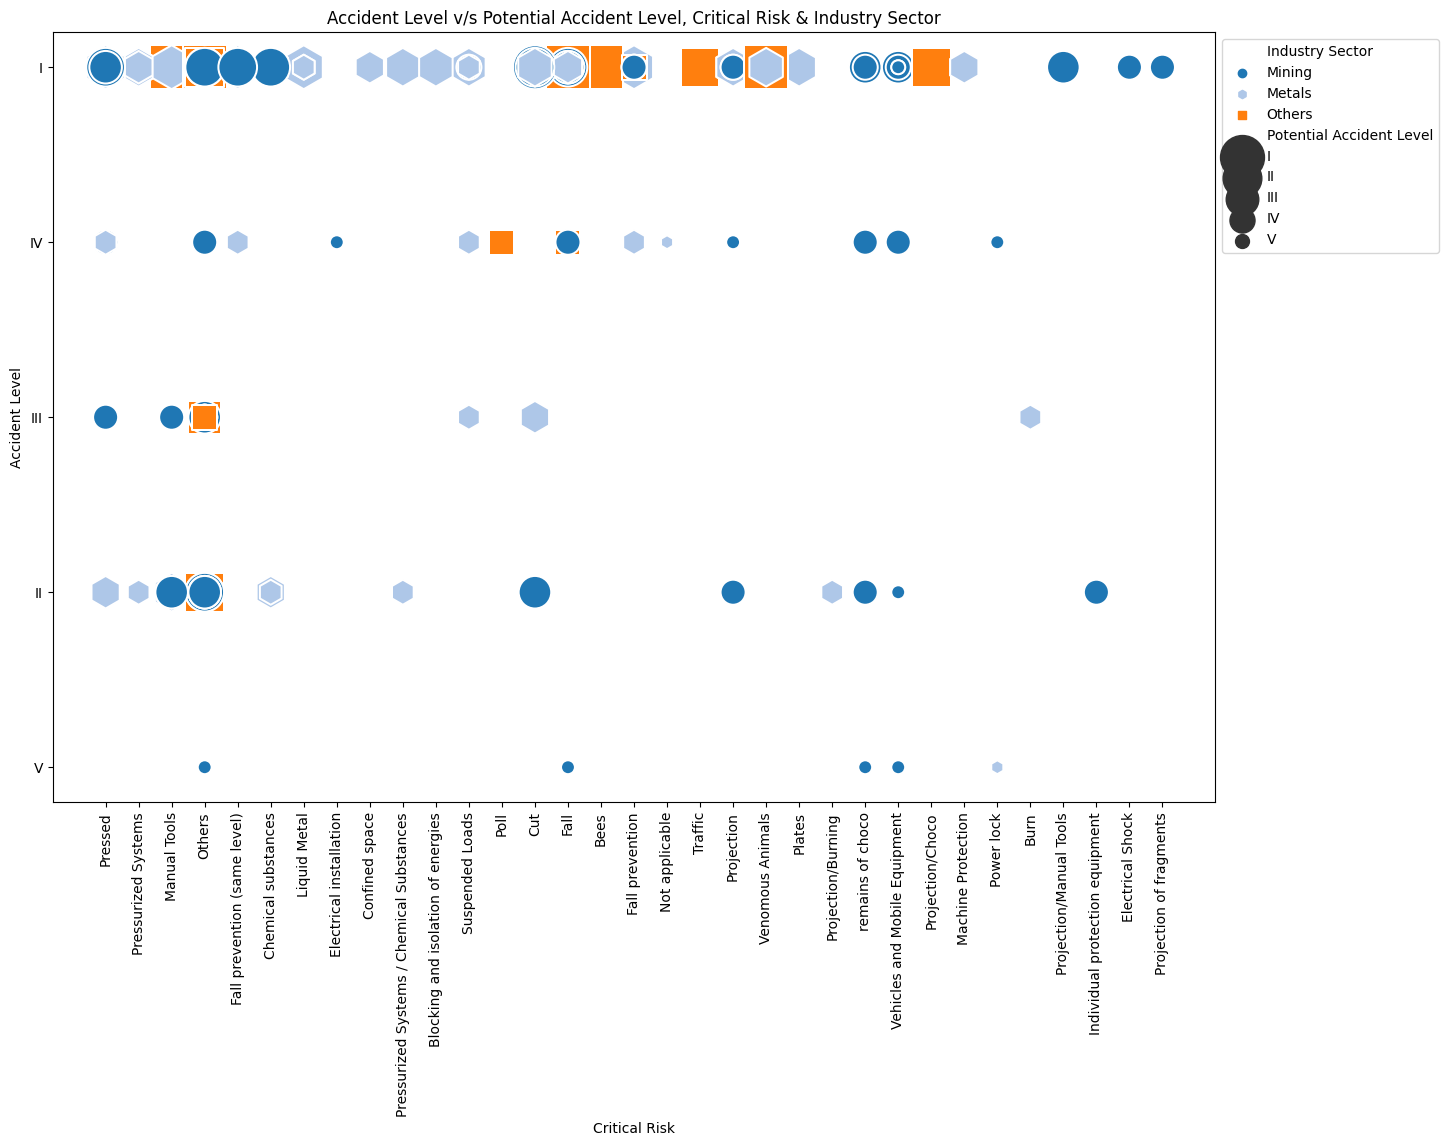

In [235]:
fig, axes = plt.subplots(figsize=(15, 10))
marker_styles = {'Mining':'o', 'Metals':'h', 'Others':'s'}
size_order = list(data['Potential Accident Level'].sort_values(ascending=True).unique())
sns.scatterplot(data=data, y='Accident Level', x='Critical Risk', hue='Industry Sector',
                style='Industry Sector', markers=marker_styles,
                size='Potential Accident Level', size_order=size_order, ax=axes, sizes=(100, 1000), palette='tab20')
axes.set_title('Accident Level v/s Potential Accident Level, Critical Risk & Industry Sector')
axes.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.show()

<b>Observations:</b><br/>
<ol>
    <li>Most of the accidents occured are the least severe ones (level I), and majority of them could've potentially been more severe as Levels II & III accidents.</li>
    <li>The most common risk seen in all industries is related to Fall - Fall & Fall Prevention.</li>
    <li>All the most severe accidents (level V) are also potentially the most severe accidents, and all the risks associated are seen in Mining industry, except 'Power Lock' which is observed as a critical risk for these accidents in Metals industry.</li>
    <li>Some of the level I accidents in Mining industry could have been level IV accidents potentially, with different risks like Electrical Installation, Projection & Power Lock. </li>
    <li>All the Level IV accidents are also marked as potentially Level IV accidents only, except accidents caused to risks of Elecrtrical Installation, Projection, Burn & one accident with no risks (Not Applicable).</li>
    <li>The following risks are only seen in Metals industry: Pressurized Systems, Liquid Metal, Confined Space, Chemicals Substances, Blocking and isolation of engines, Suspended Loads, Burn, Machine Protection, with majority of them observed in Level I accidents.</li>
    <li>Majority of Level II accidents could've potentially been Level III & IV accidents, except the ones with the risks associated in the 'Others' category.</li>
</ol>

In [236]:
def plot_bi(df, col, huecol, title, ax):
    ax = sns.countplot(data, x=col, order=data[col].value_counts().index, hue=huecol, ax=ax)
    total = len(data[col])
    for p in ax.patches:
        ht = p.get_height()
        ax.annotate(f'{ht}\n({ht / total: .1%})',
                    (p.get_x() + p.get_width() / 2., ht), ha='center', va='center',
                    size=9, xytext=(0, 3), textcoords='offset points')
    ax.set_title(title)
    return ax

Understanding Country-City mapping first

In [237]:
data[['Country', 'City']].drop_duplicates().sort_values(['Country', 'City']).reset_index(drop=True)

,Country,City
0,Country_01,Local_01
1,Country_01,Local_03
2,Country_01,Local_04
3,Country_01,Local_06
4,Country_01,Local_11
5,Country_02,Local_02
6,Country_02,Local_05
7,Country_02,Local_07
8,Country_02,Local_08
9,Country_02,Local_09


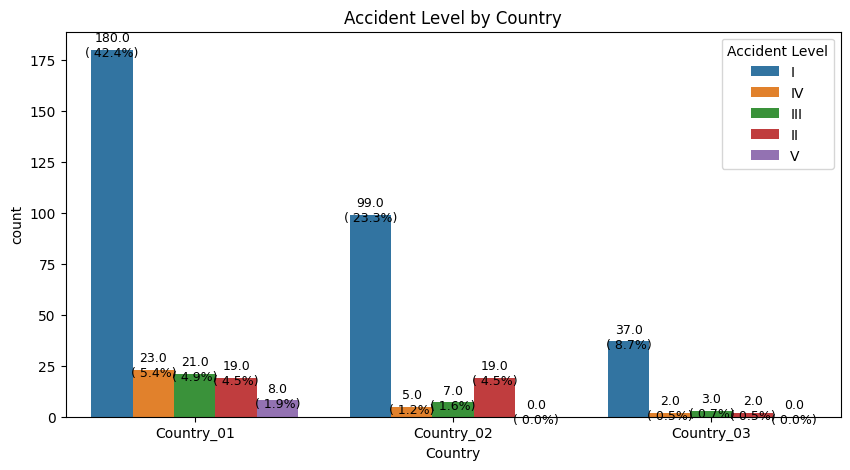

In [238]:
figure, axes = plt.subplots(1, 1, figsize=(10, 5))
plot_bi(data, 'Country', 'Accident Level', 'Accident Level by Country', axes)
plt.show()

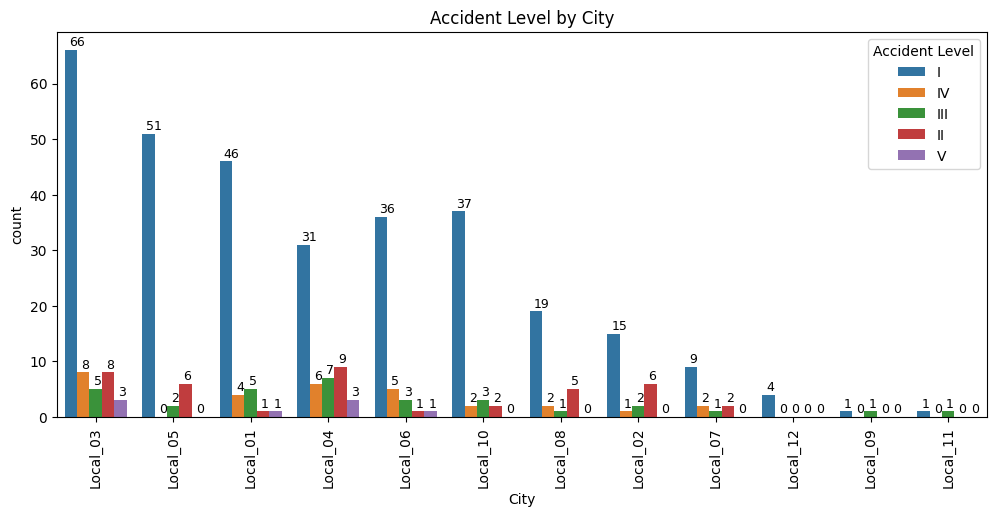

In [239]:
plt.figure(figsize=(12, 5))
ax = sns.countplot(data, x='City', order=data['City'].value_counts().index, hue='Accident Level')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()),
                (p.get_x(), p.get_height()), size=9, xytext=(3, 3), textcoords='offset points')
ax.set_title('Accident Level by City')
plt.show()

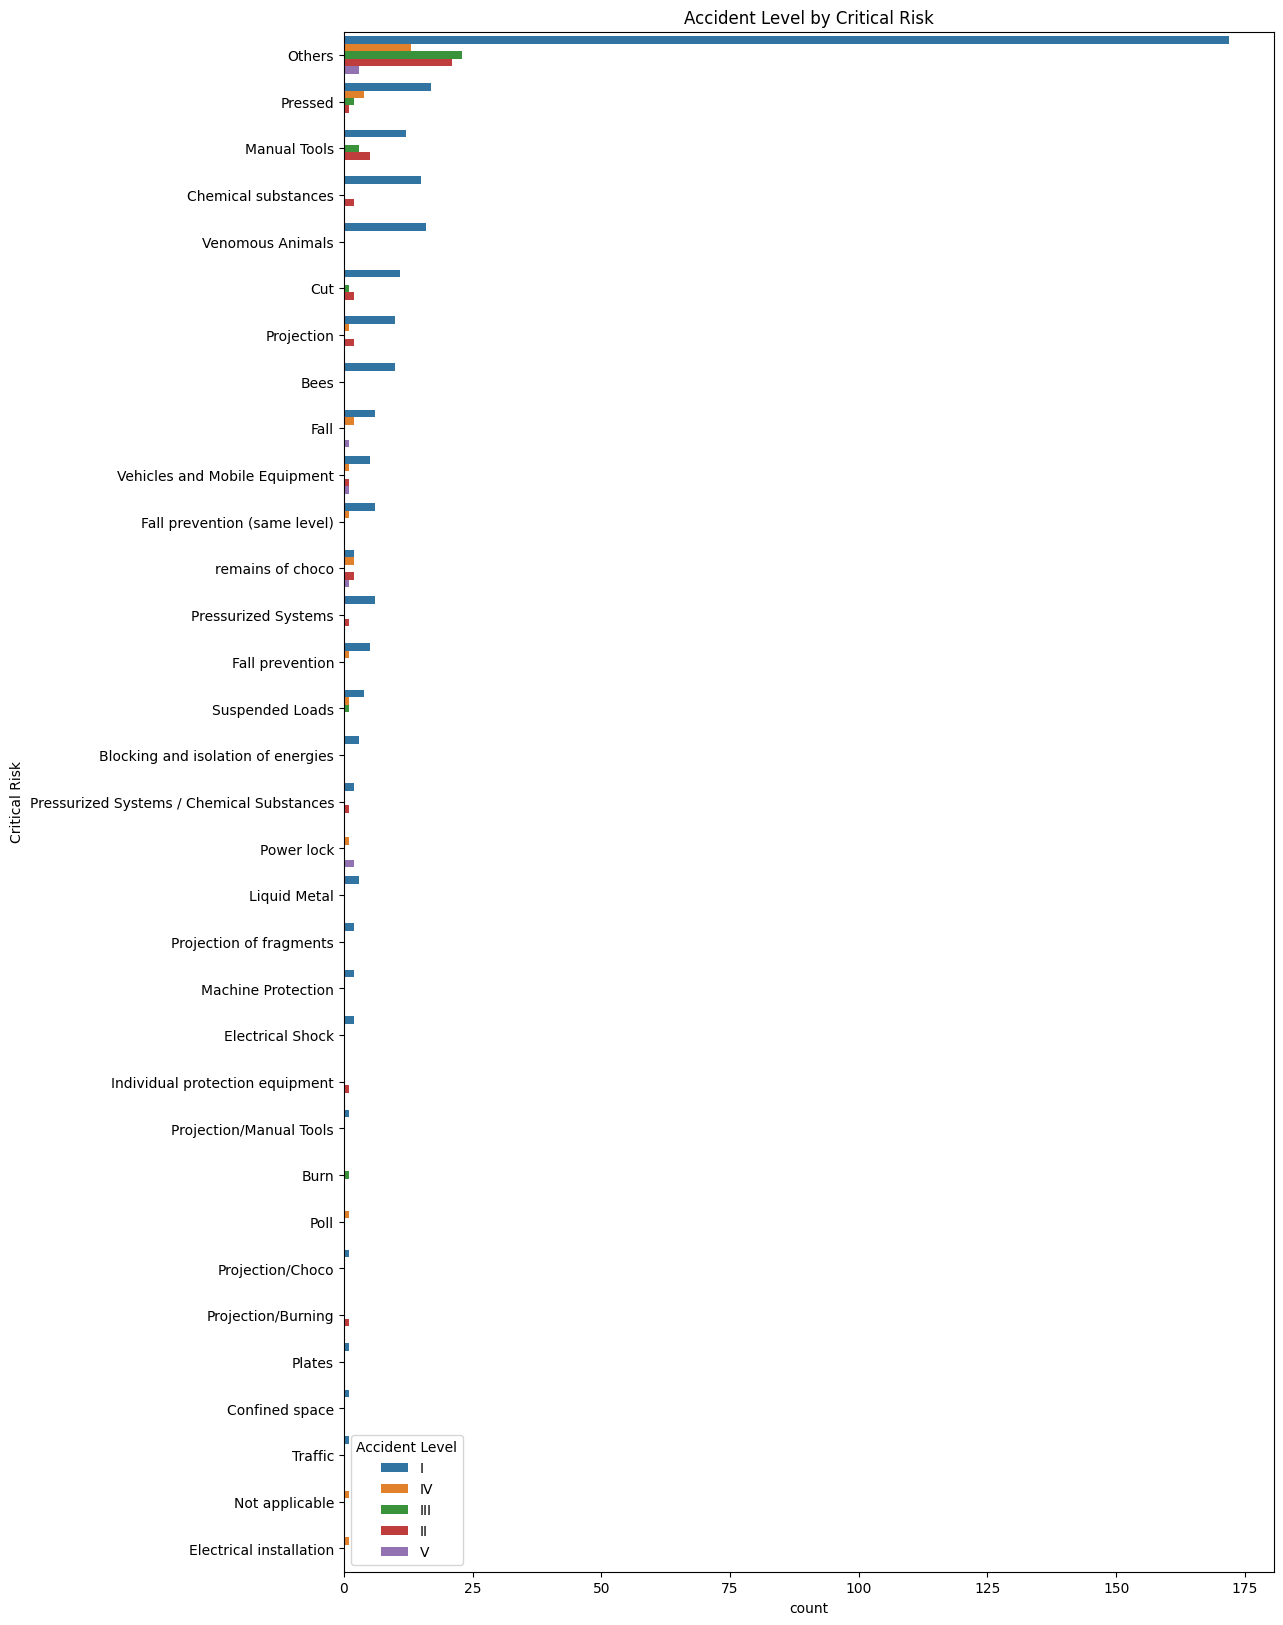

In [240]:
plt.figure(figsize=(12, 20))
sns.countplot(data, y='Critical Risk', order=data['Critical Risk'].value_counts().index, hue='Accident Level')
plt.title('Accident Level by Critical Risk')
plt.show()

<b>Observations:</b><br/>
<ol>
    <li>Country_01 witnesses the maximum accidents with a majority of low severity ones (Level I).</li>
    <li>68% of the moderately severe accidents (Levels II, II, IV) have occurred in Local_03 & Local_04 cities.</li>
    <li>Local_9, Local_11, Local_12 cities have only 2-4 accidents, could be due to low population or low staff in these plants, but we do not have any data to confirm that.</li>
    <li>Although country_02 has maximum number of plants but witnesses 2nd highest number of accidents, majority of which being least severity accidents (Level I).</li>
    <li>Plants in Local_01, Local_03, Local_04, & Local_06 cities only have faced the highest severity accidents (Level V). The risks associated could be Fall, Vehicles & Mobile Equipment, Remains of Choco & Power Lock and some are categorized under 'Others'.</li>
    <li>Most of the risks have contributed to least severe accidents of Level I, majority of which are recorded in Country_01.</li>
    <li>Risks like Cut, Chemical Substances, Manual Tools, Pressed, Projection are the causes of moderate severity accidents (Level II, II & IV)</li>
</ol>

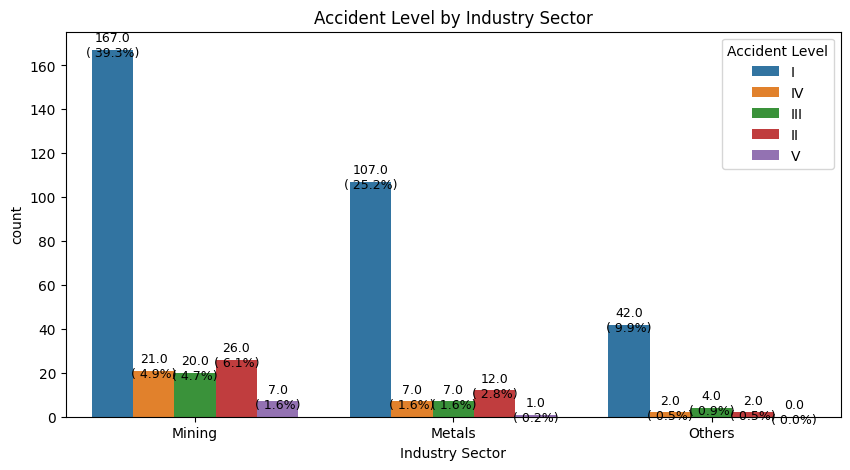

In [241]:
figure, axes = plt.subplots(1, 1, figsize=(10, 5))
plot_bi(data, 'Industry Sector', 'Accident Level', 'Accident Level by Industry Sector', axes)
plt.show()

<b>Observations:</b><br/>
<ol>
    <li>The most severe accidents (level V) are seen only in Mining & Metals industry sectors, where only 1 has occured in Metals industry & the rest in Mining industry.</li>
    <li>The 'Others' industry sector has least accidents, with majority being the least severe ones (level I).</li>
    <li>Accident Levels III & IV are almost equally distribute in Mining & Metals industry, while Level II accidents have occured more in both.</li>
</ol>

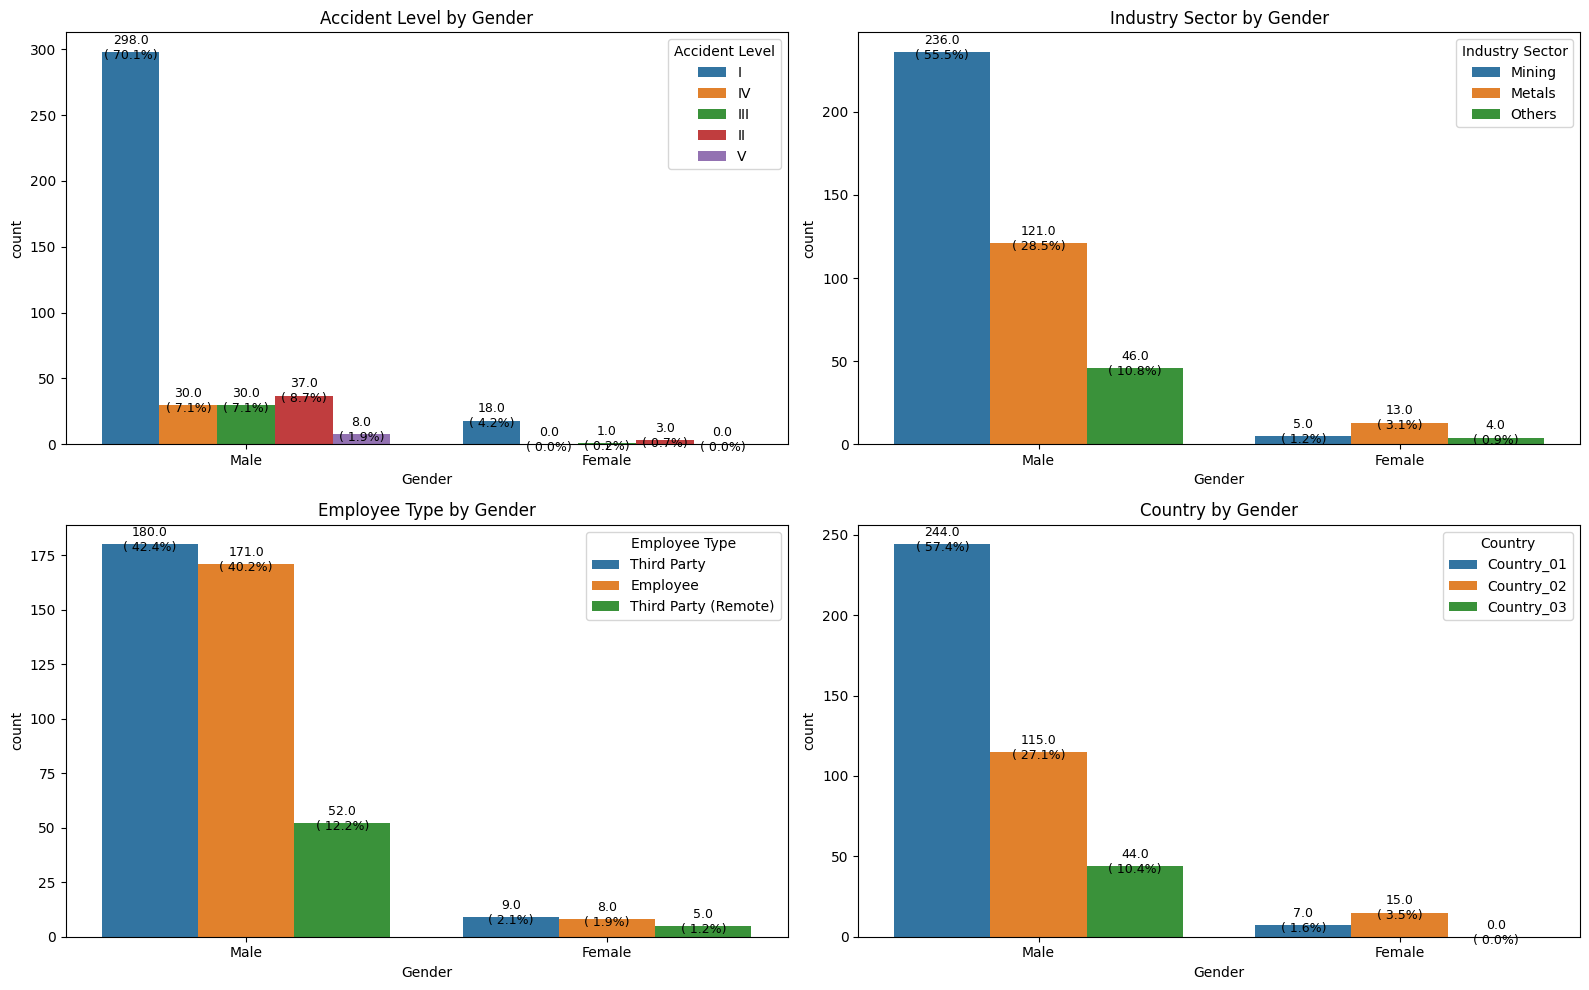

In [242]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

plot_bi(data, 'Gender', 'Accident Level', 'Accident Level by Gender', axes[0, 0])
plot_bi(data, 'Gender', 'Industry Sector', 'Industry Sector by Gender', axes[0, 1])
plot_bi(data, 'Gender', 'Employee Type', 'Employee Type by Gender', axes[1, 0])
plot_bi(data, 'Gender', 'Country', 'Country by Gender', axes[1, 1])

plt.tight_layout()
plt.show()

<b>Observations:</b><br/>
<ol>
    <li>There are no females suffered from an accident in Country_03, but even in other 2 countries together, only 6% of the accidents have females involved.</li>
    <li>About 60% of the females met with accident in Metals industry, and 23% in Mining industry, while the rest in 'Others'.</li>
    <li>There is almost equal distribution of females as different types of employees.</li>
    <li>82% of the females were involved in least severity accidents (Level I) and the rest in moderate severity ones (levels II, III, IV).</li>
    <li>87% of the men, with almost equal distribution, are either direct Employees or Third Party employees.</li>
    <li>As the accident of level I have occured more, 74% of men have met with them, but only 2% of men have suffered from most severe accidents (Level V), with no women involved in these.</li>
</ol>

Text(0, 0.5, 'count')

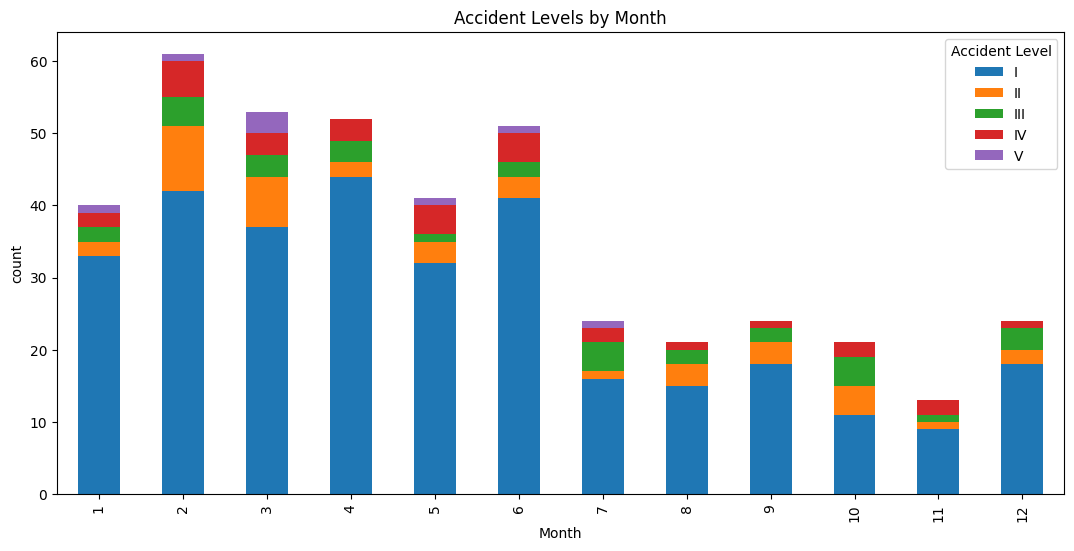

In [243]:
count = pd.crosstab(columns=data['Accident Level'], index=data['Month'])
ax = count.plot(kind='bar', stacked=True, figsize=(13, 6))
ax.set_title('Accident Levels by Month')
ax.set_ylabel('count')

Text(0, 0.5, 'count')

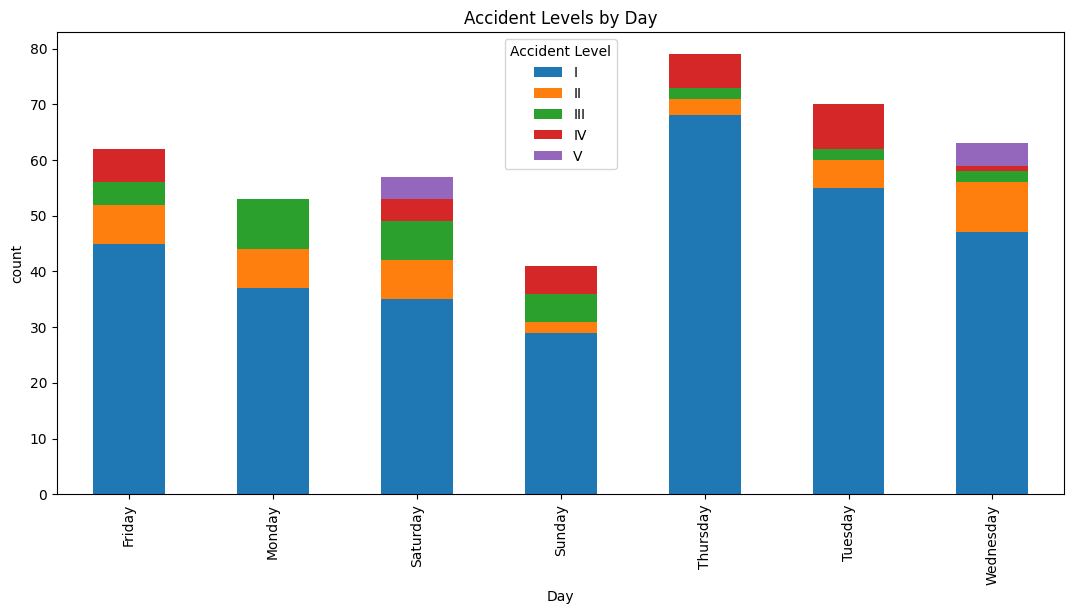

In [244]:
count = pd.crosstab(columns=data['Accident Level'], index=data['Day'])
ax = count.plot(kind='bar', stacked=True, figsize=(13, 6))
ax.set_title('Accident Levels by Day')
ax.set_ylabel('count')

<b>Observations:</b><br/>
<ol>
    <li>Majority of potentially high severity accidents (level V) are seen in the month of March and especially on Wednesdays & Saturdays of the week.</li>
    <li>Majority of moderate severity accidents (levels II, III, IV) are seen in February & March.</li>
    <li>Majority of potentially least severe accidents (level I) are seen in first half of the year. But these numbers don't include data post 9th July 2017, hence this does not provide a full view.</li>
	<li>Monday has witnessed only Level I, II & II accidents, while Level IV accidents have mostly occured on Tuesday, Thursday, Friday & Sunday.</li>
</ol>

### Step 3: Data preprocessing (NLP Preprocessing techniques)

We will work on the Description column here, which will help us identify the real causes of these accidents.

In [245]:
pp_data = data.copy()
pp_data['Description'].head()

0                                                                                                             While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.
1                                                                                                                                                                                                                                                                   During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of t

In [246]:
# Checking if there are any UTF-8 characters
def check_beyond_ascii(text):
    return all(ord(char) > 128 for char in text)

pp_data['Has_outside_ASCII'] = pp_data['Description'].apply(check_beyond_ascii)

if((pp_data['Has_outside_ASCII'].unique()[0]==False) | (len(pp_data['Has_outside_ASCII'].unique())==2)):
    print(pp_data['Has_outside_ASCII'].unique(), ': There are no characters beyond the range of ASCII character set.')
else:
    print(pp_data['Has_outside_ASCII'].unique(), ': There are characters beyond the range of ASCII character set. Please remove them.')
pp_data.drop('Has_outside_ASCII', axis=1, inplace=True)

[False] : There are no characters beyond the range of ASCII character set.


In [247]:
# Checking if there are any HTML tags or URLs
def check_html_urls(text):
    check_pattern = re.compile(r'https?://\S+|www\.\S+|<[^>]+>')
    return bool(check_pattern.search(text))

# Assuming pp_data is a DataFrame with a 'Description' column
pp_data['Has_HTML_URLs'] = pp_data['Description'].apply(check_html_urls)
if((pp_data['Has_HTML_URLs'].unique()[0]==False) | (len(pp_data['Has_HTML_URLs'].unique())==2)):
    print(pp_data['Has_HTML_URLs'].unique(), ': There are no HTML tags or URLs in the data.')
else:
    print(pp_data['Has_HTML_URLs'].unique(), ': There are HTML tags or URLs in the data. Please remove them.')
pp_data.drop('Has_HTML_URLs', axis=1, inplace=True)

[False] : There are no HTML tags or URLs in the data.


There are no characters beyond ASCII character set range and no HTML tags or URLs in the dataset. <br/>
The numbers in the text are used for measurements, time, etc. hence provide meaningful information, but will not be helpful during vectorization and modelling, as it would add more noise and sparsity. Hence, we decided to retain only alphabetic characters.

##### PRE-PROCESSING FUNCTION

In [248]:
def pre_processing(text):
    # Lowercasing the entire text
    text = text.lower()

    # Dealing with accented characters and unicodes by using Unicode normalization
    text = unidecode(text)
    text = unicodedata.normalize('NFKD', text)

    # Retaining only alphabetic characters
    text = ' '.join(re.compile(r'[a-z]+').findall(text))

    # Removing English Stopwords
    stopwords_list = set(stopwords.words('english'))
    text = ' '.join([word for word in word_tokenize(text) if word not in stopwords_list])

    # Lemmatizing the text now
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])

    return text

In [249]:
pp_data['Description'] = pp_data['Description'].apply(pre_processing)

In [250]:
pp_data['Description'].head()

0                                                                              removing drill rod jumbo maintenance supervisor proceeds loosen support intermediate centralizer facilitate removal seeing mechanic support one end drill equipment pull hand bar accelerate removal moment bar slide point support tightens finger mechanic drilling bar beam jumbo
1                                                                                                                                                      activation sodium sulphide pump piping uncoupled sulfide solution designed area reach maid immediately made use emergency shower directed ambulatory doctor later hospital note sulphide solution gram liter
2                                                                                                                                                                sub station milpo located level collaborator excavation work pick hand tool hitting rock flat part beak bounce hitting steel ti

Text(0.5, 1.0, 'Accident Description Word Cloud')

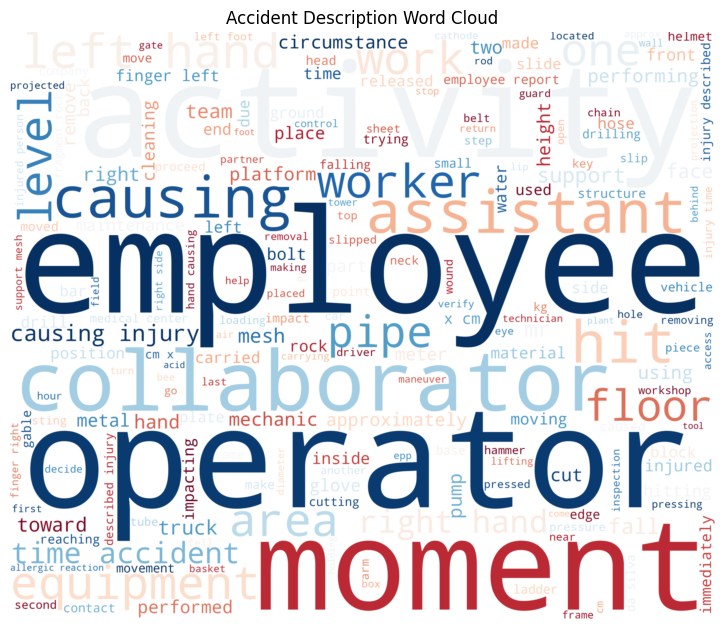

In [251]:
descriptions = ' '.join(pp_data['Description'])
descriptions = ' '.join([word for word in descriptions.split()])

descriptions_wc = WordCloud(stopwords=STOPWORDS, colormap='RdBu', background_color='white',
                            width=3000, height=2500).generate(descriptions)

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(descriptions_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Accident Description Word Cloud')

Let's perform POS tagging to verify this.

##### POS TAGGING

In [252]:
description_list = pp_data['Description'].tolist()
pos_tags = [pos_tag(word_tokenize(desc)) for desc in description_list]
pp_data['POS_Tags'] = pos_tags

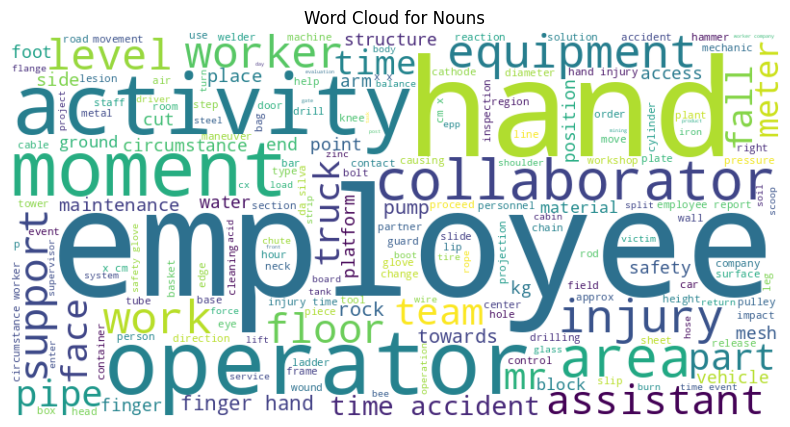

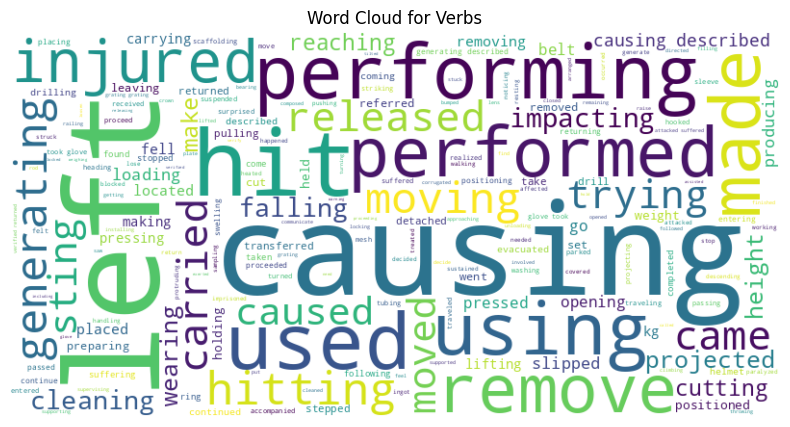

In [253]:
# Flatten the list of POS tags
flat_pos_tags = [tag[0] for sublist in pos_tags for _, tag in sublist]

# Get all nouns and verbs
nouns = [word for word, tag in zip(word_tokenize(" ".join(description_list)), flat_pos_tags) if tag.startswith('N')]
verbs = [word for word, tag in zip(word_tokenize(" ".join(description_list)), flat_pos_tags) if tag.startswith('V')]

# Create WordCloud for Nouns
noun_wc = WordCloud(width=800, height=400, background_color='white').generate(" ".join(nouns))
plt.figure(figsize=(10, 5))
plt.imshow(noun_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Nouns')
plt.show()

# Create WordCloud for Verbs
verb_wc = WordCloud(width=800, height=400, background_color='white').generate(" ".join(verbs))
plt.figure(figsize=(10, 5))
plt.imshow(verb_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Verbs')
plt.show()

<b>Observations:</b><br/>
<ol>
    <li>There are a lot of action words like: falling, cutting, drilling, hitting, cleaning, slipped, injured, carried, moving, pressing, etc. These actions must have led to the accident.</li>
    <li>There are a lot of nouns which can also help us understand the object causing the accident, like: truck, pipe, bee, vehicle, tube, floor, support mesh, ladder, helmet, metal, bolt, rock, water, tool, sting, equipment, etc.</li>
</ol>

In [254]:
pp_data.head()

,Date,Country,City,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee Type,Critical Risk,Description,Year,Month,Day,POS_Tags
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,removing drill rod jumbo maintenance supervisor proceeds loosen support intermediate centralizer facilitate removal seeing mechanic support one end drill equipment pull hand bar accelerate removal moment bar slide point support tightens finger mechanic drilling bar beam jumbo,2016,1,Friday,"[(removing, VBG), (drill, NN), (rod, VB), (jumbo, JJ), (maintenance, NN), (supervisor, NN), (proceeds, NNS), (loosen, VBP), (support, NN), (intermediate, JJ), (centralizer, NN), (facilitate, NN), (removal, NN), (seeing, VBG), (mechanic, JJ), (support, NN), (one, CD), (end, NN), (drill, NN), (equipment, NN), (pull, NN), (hand, NN), (bar, NN), (accelerate, NN), (removal, NN), (moment, NN), (bar, NN), (slide, NN), (point, NN), (support, NN), (tightens, NNS), (finger, VBP), (mechanic, JJ), (drilling, NN), (bar, NN), (beam, NN), (jumbo, NN)]"
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,activation sodium sulphide pump piping uncoupled sulfide solution designed area reach maid immediately made use emergency shower directed ambulatory doctor later hospital note sulphide solution gram liter,2016,1,Saturday,"[(activation, NN), (sodium, NN), (sulphide, JJ), (pump, NN), (piping, VBG), (uncoupled, JJ), (sulfide, JJ), (solution, NN), (designed, VBN), (area, NN), (reach, NN), (maid, VBD), (immediately, RB), (made, VBN), (use, NN), (emergency, NN), (shower, NN), (directed, VBD), (ambulatory, JJ), (doctor, NN), (later, RBR), (hospital, JJ), (note, NN), (sulphide, JJ), (solution, NN), (gram, NN), (liter, NN)]"
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,sub station milpo located level collaborator excavation work pick hand tool hitting rock flat part beak bounce hitting steel tip safety shoe metatarsal area left foot collaborator causing injury,2016,1,Wednesday,"[(sub, JJ), (station, NN), (milpo, NN), (located, VBN), (level, NN), (collaborator, NN), (excavation, NN), (work, NN), (pick, JJ), (hand, NN), (tool, NN), (hitting, VBG), (rock, NN), (flat, JJ), (part, NN), (beak, NN), (bounce, NN), (hitting, VBG), (steel, NN), (tip, NNS), (safety, NN), (shoe, NN), (metatarsal, JJ), (area, NN), (left, VBD), (foot, JJ), (collaborator, NN), (causing, VBG), (injury, NN)]"
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,approximately nv cx ob personnel begin task unlocking soquet bolt bhb machine penultimate bolt identified hexagonal head worn proceeding mr cristobal auxiliary assistant climb platform exert pressure hand dado key prevent coming bolt moment two collaborator rotate lever anti clockwise direction leaving key bolt hitting palm left hand causing injury,2016,1,Friday,"[(approximately, RB), (nv, JJ), (cx, NN), (ob, NN), (personnel, NNS), (begin, VBP), (task, NN), (unlocking, JJ), (soquet, NN), (bolt, NN), (bhb, NN), (machine, NN), (penultimate, NN), (bolt, NN), (identified, VBD), (hexagonal, JJ), (head, NN), (worn, IN), (proceeding, VBG), (mr, NN), (cristobal, JJ), (auxiliary, JJ), (assistant, NN), (climb, NN), (platform, NN), (exert, JJ), (pressure, NN), (hand, NN), (dado, NN), (key, JJ), (prevent, NN), (coming, VBG), (bolt, JJ), (moment, NN), (two, CD), (collaborator, NN), (rotate, NN), (lever, NN), (anti, VBP), (clockwise, JJ), (direction, NN), (leaving, VBG), (key, JJ), (bolt, NN), (hitting, VBG), (palm, NN), (left, VBD), (hand, NN), (causing, VBG), (injury, NN)]"
4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,approximately circumstance mechanic anthony group leader eduardo eric fernandez injured three company impromec performed removal pulley motor pump zaf marcy cm length cm weight kg locked proceed heating pulley loosen come fall distance meter high hit instep right foot worker causing injury described,2016,1,Sunday,"[(approx

### Step 4: Data preparation - Cleansed data in .xlsx or .csv file

##### TOKENIZATION

In [255]:
# Using SpaCy for Tokenization
spacy_eng = spacy.load('en_core_web_sm')
pp_data['Description'] = pp_data['Description'].astype(str)
pp_data['Tokenized Text'] = pp_data['Description'].apply(lambda x: [token.text for token in spacy_eng(x)])
pp_data.head()

,Date,Country,City,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee Type,Critical Risk,Description,Year,Month,Day,POS_Tags,Tokenized Text
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,removing drill rod jumbo maintenance supervisor proceeds loosen support intermediate centralizer facilitate removal seeing mechanic support one end drill equipment pull hand bar accelerate removal moment bar slide point support tightens finger mechanic drilling bar beam jumbo,2016,1,Friday,"[(removing, VBG), (drill, NN), (rod, VB), (jumbo, JJ), (maintenance, NN), (supervisor, NN), (proceeds, NNS), (loosen, VBP), (support, NN), (intermediate, JJ), (centralizer, NN), (facilitate, NN), (removal, NN), (seeing, VBG), (mechanic, JJ), (support, NN), (one, CD), (end, NN), (drill, NN), (equipment, NN), (pull, NN), (hand, NN), (bar, NN), (accelerate, NN), (removal, NN), (moment, NN), (bar, NN), (slide, NN), (point, NN), (support, NN), (tightens, NNS), (finger, VBP), (mechanic, JJ), (drilling, NN), (bar, NN), (beam, NN), (jumbo, NN)]","[removing, drill, rod, jumbo, maintenance, supervisor, proceeds, loosen, support, intermediate, centralizer, facilitate, removal, seeing, mechanic, support, one, end, drill, equipment, pull, hand, bar, accelerate, removal, moment, bar, slide, point, support, tightens, finger, mechanic, drilling, bar, beam, jumbo]"
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,activation sodium sulphide pump piping uncoupled sulfide solution designed area reach maid immediately made use emergency shower directed ambulatory doctor later hospital note sulphide solution gram liter,2016,1,Saturday,"[(activation, NN), (sodium, NN), (sulphide, JJ), (pump, NN), (piping, VBG), (uncoupled, JJ), (sulfide, JJ), (solution, NN), (designed, VBN), (area, NN), (reach, NN), (maid, VBD), (immediately, RB), (made, VBN), (use, NN), (emergency, NN), (shower, NN), (directed, VBD), (ambulatory, JJ), (doctor, NN), (later, RBR), (hospital, JJ), (note, NN), (sulphide, JJ), (solution, NN), (gram, NN), (liter, NN)]","[activation, sodium, sulphide, pump, piping, uncoupled, sulfide, solution, designed, area, reach, maid, immediately, made, use, emergency, shower, directed, ambulatory, doctor, later, hospital, note, sulphide, solution, gram, liter]"
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,sub station milpo located level collaborator excavation work pick hand tool hitting rock flat part beak bounce hitting steel tip safety shoe metatarsal area left foot collaborator causing injury,2016,1,Wednesday,"[(sub, JJ), (station, NN), (milpo, NN), (located, VBN), (level, NN), (collaborator, NN), (excavation, NN), (work, NN), (pick, JJ), (hand, NN), (tool, NN), (hitting, VBG), (rock, NN), (flat, JJ), (part, NN), (beak, NN), (bounce, NN), (hitting, VBG), (steel, NN), (tip, NNS), (safety, NN), (shoe, NN), (metatarsal, JJ), (area, NN), (left, VBD), (foot, JJ), (collaborator, NN), (causing, VBG), (injury, NN)]","[sub, station, milpo, located, level, collaborator, excavation, work, pick, hand, tool, hitting, rock, flat, part, beak, bounce, hitting, steel, tip, safety, shoe, metatarsal, area, left, foot, collaborator, causing, injury]"
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,approximately nv cx ob personnel begin task unlocking soquet bolt bhb machine penultimate bolt identified hexagonal head worn proceeding mr cristobal auxiliary assistant climb platform exert pressure hand dado key prevent coming bolt moment two collaborator rotate lever anti clockwise direction leaving key bolt hitting palm left hand causing injury,2016,1,Friday,"[(approximately, RB), (nv, JJ), (cx, NN), (ob, NN), (personnel, NNS), (begin, VBP), (task, NN), (unlocking, JJ), (soquet, NN), (bolt, NN), (bhb, NN), (machine, NN), (penultimate, NN), (bolt, NN), (identified, VBD), (hexagonal, JJ), (head, NN), (worn, IN), (proceeding, VBG), (mr, NN), (cristobal, JJ), (auxiliary,

##### N-GRAMS

In [256]:
# Finding n-grams for the Description
def generate_ngrams(text, n):
    doc = spacy_eng(text)
    ngrams = list(zip(*[doc[i:] for i in range (n)]))
    return [' '.join(tokens.text for tokens in ng) for ng in ngrams]

pp_data['Uni-grams'] = pp_data['Description'].apply(lambda x: generate_ngrams(x, 1))
pp_data['Bi-grams'] = pp_data['Description'].apply(lambda x: generate_ngrams(x, 2))
pp_data['Tri-grams'] = pp_data['Description'].apply(lambda x: generate_ngrams(x, 3))

pp_data.head()

,Date,Country,City,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee Type,Critical Risk,Description,Year,Month,Day,POS_Tags,Tokenized Text,Uni-grams,Bi-grams,Tri-grams
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,removing drill rod jumbo maintenance supervisor proceeds loosen support intermediate centralizer facilitate removal seeing mechanic support one end drill equipment pull hand bar accelerate removal moment bar slide point support tightens finger mechanic drilling bar beam jumbo,2016,1,Friday,"[(removing, VBG), (drill, NN), (rod, VB), (jumbo, JJ), (maintenance, NN), (supervisor, NN), (proceeds, NNS), (loosen, VBP), (support, NN), (intermediate, JJ), (centralizer, NN), (facilitate, NN), (removal, NN), (seeing, VBG), (mechanic, JJ), (support, NN), (one, CD), (end, NN), (drill, NN), (equipment, NN), (pull, NN), (hand, NN), (bar, NN), (accelerate, NN), (removal, NN), (moment, NN), (bar, NN), (slide, NN), (point, NN), (support, NN), (tightens, NNS), (finger, VBP), (mechanic, JJ), (drilling, NN), (bar, NN), (beam, NN), (jumbo, NN)]","[removing, drill, rod, jumbo, maintenance, supervisor, proceeds, loosen, support, intermediate, centralizer, facilitate, removal, seeing, mechanic, support, one, end, drill, equipment, pull, hand, bar, accelerate, removal, moment, bar, slide, point, support, tightens, finger, mechanic, drilling, bar, beam, jumbo]","[removing, drill, rod, jumbo, maintenance, supervisor, proceeds, loosen, support, intermediate, centralizer, facilitate, removal, seeing, mechanic, support, one, end, drill, equipment, pull, hand, bar, accelerate, removal, moment, bar, slide, point, support, tightens, finger, mechanic, drilling, bar, beam, jumbo]","[removing drill, drill rod, rod jumbo, jumbo maintenance, maintenance supervisor, supervisor proceeds, proceeds loosen, loosen support, support intermediate, intermediate centralizer, centralizer facilitate, facilitate removal, removal seeing, seeing mechanic, mechanic support, support one, one end, end drill, drill equipment, equipment pull, pull hand, hand bar, bar accelerate, accelerate removal, removal moment, moment bar, bar slide, slide point, point support, support tightens, tightens finger, finger mechanic, mechanic drilling, drilling bar, bar beam, beam jumbo]","[removing drill rod, drill rod jumbo, rod jumbo maintenance, jumbo maintenance supervisor, maintenance supervisor proceeds, supervisor proceeds loosen, proceeds loosen support, loosen support intermediate, support intermediate centralizer, intermediate centralizer facilitate, centralizer facilitate removal, facilitate removal seeing, removal seeing mechanic, seeing mechanic support, mechanic support one, support one end, one end drill, end drill equipment, drill equipment pull, equipment pull hand, pull hand bar, hand bar accelerate, bar accelerate removal, accelerate removal moment, removal moment bar, moment bar slide, bar slide point, slide point support, point support tightens, support tightens finger, tightens finger mechanic, finger mechanic drilling, mechanic drilling bar, drilling bar beam, bar beam jumbo]"
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,activation sodium sulphide pump piping uncoupled sulfide solution designed area reach maid immediately made use emergency shower directed ambulatory doctor later hospital note sulphide solution gram liter,2016,1,Saturday,"[(activation, NN), (sodium, NN), (sulphide, JJ), (pump, NN), (piping, VBG), (uncoupled, JJ), (sulfide, JJ), (solution, NN), (designed, VBN), (area, NN), (reach, NN), (maid, VBD), (immediately, RB), (made, VBN), (use, NN), (emergency, NN), (shower, NN), (directed, VBD), (ambulatory, JJ), (doctor, NN), (later, RBR), (hospital, JJ), (note, NN), (sulphide, JJ), (solution, NN), (gram, NN), (liter, NN)]","[activation, sodium, sulphide, pump, piping, uncoupled, sulfide, solution, designed, area, reach, maid, immediately, made, use, emergency, shower, directed, amb

In [257]:
# Let's find the most frequent n-grams
unigm = [ng for sublist in pp_data['Uni-grams'] for ng in sublist]
bigm = [ng for sublist in pp_data['Bi-grams'] for ng in sublist]
trigm = [ng for sublist in pp_data['Tri-grams'] for ng in sublist]

freq_unigm = pd.DataFrame(Counter(unigm).most_common(), columns=['Uni-gram', 'Frequency'])
freq_bigm = pd.DataFrame(Counter(bigm).most_common(), columns=['Bi-gram', 'Frequency'])
freq_trigm = pd.DataFrame(Counter(trigm).most_common(), columns=['Tri-gram', 'Frequency'])

print('Most frequent Uni-grams: \n', freq_unigm.head(20))
print('Most frequent Bi-grams: \n', freq_bigm.head(20))
print('Most frequent Tri-grams: \n', freq_trigm.head(20))

Most frequent Uni-grams: 
         Uni-gram  Frequency
0       employee        183
1           hand        181
2        causing        166
3           left        160
4          right        155
5       operator        133
6       activity        120
7           time        112
8         injury        111
9         moment        103
10        worker         90
11  collaborator         84
12          area         81
13           one         80
14          work         80
15     equipment         78
16        finger         76
17     assistant         75
18      accident         73
19          pipe         72
Most frequent Bi-grams: 
              Bi-gram  Frequency
0          left hand         70
1         right hand         57
2      time accident         56
3     causing injury         55
4        finger left         25
5               x cm         23
6    employee report         22
7   injury described         20
8               cm x         18
9           da silva         18
10    m

The most frequent Bi-grams provide useful information regarding the cause of accident, while the unigrams seem to get covered in bi-grams and the tri-grams do not seem to be adding any useful information on top of bi-grams. For Example: 'injury', 'causing injury' & 'causing injury described'. Hence, we can use the range of only 2 during vector encodings.

##### SAVING THE PRE-PROCESSED DATA FILE IN .CSV FORMAT

In [258]:
output_path = str('/content/drive/MyDrive/Colab Notebooks/Capstone/IHMStefanini_industrial_safety_and_health_cleansed.csv')
pp_data.to_csv(output_path, index=False)

##### VECTOR ENCODING VIA TF-IDF

In [259]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(2, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(description_list)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_df.head()

,access aripuana,access ladder,accident employee,accident operator,accident victim,accident worker,accompanied geologist,activity area,activity chuteo,activity employee,...,work area,work moment,work normally,worker causing,worker company,worker time,worker used,worker wearing,workshop level,wound right
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.350469,0.0,0.0,0.0,0.0,0.0,0.0


In [260]:
tfidf_df.shape

(425, 1000)

In [261]:
# Display the most important features
tfidf_scores = tfidf_df.sum(axis=0)
tfidf_scores_df = pd.DataFrame({'Feature': tfidf_vectorizer.get_feature_names_out(), 'TF-IDF Score': tfidf_scores})

top_features = tfidf_scores_df.sort_values(by='TF-IDF Score', ascending=False)

print("Top Features:")
print(top_features.head(30))

Top Features:
                                 Feature  TF-IDF Score
left hand                      left hand     16.026339
right hand                    right hand     13.926010
causing injury            causing injury     13.242063
time accident              time accident     10.120484
employee report          employee report      8.380265
finger left                  finger left      7.739658
injury described        injury described      6.511859
medical center            medical center      6.181397
left foot                      left foot      5.524003
right leg                      right leg      5.479867
described injury        described injury      5.202557
finger right                finger right      4.763424
hand causing                hand causing      4.761339
cm cm                              cm cm      4.331312
generating injury      generating injury      4.217899
injured person            injured person      4.186464
hit right                      hit right      4.007

You can see most of the accidents are related to injuries on hands, fingers, feet, legs.

##### VECTOR ENCODING VIA WORD2VEC

In [262]:
tokens_list = pp_data['Tokenized Text'].to_list()
word2vec_vectorizer = Word2Vec(sentences=tokens_list, vector_size=1000, window=5, min_count=1, workers=4)

def get_sentence_vector(sentence, vectorizer):
    vector_sum = 0
    for word in sentence:
        if word in vectorizer.wv:
            vector_sum += vectorizer.wv[word]
    return vector_sum

pp_data['Description_Vector'] = [get_sentence_vector(sentence, word2vec_vectorizer) for sentence in tokens_list]

pp_data[['Description', 'Description_Vector']]

,Description,Description_Vector
0,removing drill rod jumbo maintenance supervisor proceeds loosen support intermediate centralizer facilitate removal seeing mechanic support one end drill equipment pull hand bar accelerate removal moment bar slide point support tightens finger mechanic drilling bar beam jumbo,"[0.15707801, 0.03292122, 0.05958762, 0.056937147, -0.029617732, -0.0032965657, 0.031621538, 0.057248697, -0.039563842, 0.013816019, 0.053082425, 0.00841797, -0.025922272, 0.01781382, 0.08120937, 0.0055661416, -0.042670015, -0.0010247729, 0.065751046, -0.13239953, 0.038823504, -0.07142882, 0.009745223, 0.00088176626, 0.059998784, -0.04880272, 0.047964007, -0.04229665, -0.1736844, 0.0601036, 0.06277758, -0.05786401, -0.042443924, -0.044334296, 0.077074185, -0.040765252, 0.05147874, 0.02051036, -0.04544442, -0.118099354, -0.035529453, 0.03527759, -0.0990722, 0.113670886, 0.0020931938, -0.01621403, -0.050131336, 0.07557952, -0.09698778, 0.022129202, -0.0057565337, -0.024100147, -0.001655862, -0.09964007, 0.0068400763, -0.0067252843, 0.051770598, -0.010854034, -0.044485725, -0.031685956, -0.061581593, -0.016384685, -0.06673388, 0.031010777, -0.009073342, 0.084978946, 0.010415323, 0.12663256, -0.012578272, -0.016179036, 0.004263751, -0.022461588, 0.06182182, -0.054713853, 0.008811762, 0.011789852, 0.017140297, -0.017415095, 0.017906778, -0.011309964, -0.02911515, -0.0046041887, -0.07211805, 0.10367081, -0.11736289, 0.018598873, -0.051587373, 0.04676849, 0.06196549, 0.058311213, -0.009081672, -0.00092049176, -0.018355303, 0.10423441, 0.10061874, 0.04016074, 0.11104151, -0.10117382, 0.04390468, 0.03518105, ...]"
1,activation sodium sulphide pump piping uncoupled sulfide solution designed area reach maid immediately made use emergency shower directed ambulatory doctor later hospital note sulphide solution gram liter,"[0.050159547, 0.0034498537, 0.013865723, 0.019556768, -0.009535587, -0.0048997034, 0.007474934, 0.008397666, -0.015005418, -0.0011243587, 0.020567374, 0.0012030369, -0.0018750269, 0.0027484135, 0.025572246, 0.004091182, -0.011384836, 0.009632818, 0.01891898, -0.030647473, 0.009614129, -0.018889962, 0.000208552, -0.0015585553, 0.018383116, -0.018067654, 0.011527711, -0.012968563, -0.04778867, 0.02300469, 0.015717145, -0.01604284, -0.008446804, -0.0081007825, 0.023125794, -0.014244969, 0.013798555, 0.006104688, -0.013904105, -0.031803526, -0.00981544, 0.0075824354, -0.027628927, 0.028288098, -0.00702009, -0.0019893928, -0.013661907, 0.024018923, -0.02496692, 0.001449355, 0.0025923192, -0.005394272, 0.0010481677, -0.026285538, -0.003100835, -0.0023248564, 0.020655623, -0.005867505, -0.008903919, -0.007015261, -0.0145362355, -0.0062808865, -0.017527731, 0.007178866, -0.00025225722, 0.025718901, 0.0049676243, 0.035999503, 0.0010913804, 0.0054808888, 0.0015333262, -0.010084928, 0.01283381, -0.014078722, 0.00636521, -0.003827399, 0.007805618, 0.0009956837, 0.0028230604, -0.0007410511, -0.007905979, 0.0025470548, -0.02128871, 0.029314116, -0.02920002, 0.0004248821, -0.019476246, 0.014408904, 0.012527564, 0.019050617, 0.00083560223, -0.004493629, -0.009945758, 0.029701933, 0.021425705, 0.009401588, 0.03542433, -0.02480802, 0.008853758, 0.0066806218, ...]"
2,sub station milpo located level collaborator excavation work pick hand tool hitting rock flat part beak bounce hitting steel tip safety shoe metatarsal area left foot collaborator causing injury,"[0.13371418, 0.021866906, 0.044161554, 0.048490863, -0.026716262, -0.0062663713, 0.024536164, 0.052404746, -0.032569524, 0.0034290222, 0.037774306, 0.0061519574, -0.019586058, 0.021748114, 0.06578, 0.0008536357, -0.032360565, 0.0046101483, 0.057643846, -0.10296599, 0.03272101, -0.060298014, 0.0054757474, -0.011216852, 0.052566204, -0.04160957, 0.04244209, -0.033504058, -0.1478896, 0.046932597, 0.053325366, -0.049796976, -0.035508804, -0.033887595, 0.058084328, -0.032324746, 0.04009194, 0.01518782, -0.039097007, -0.09696262, -0.025745582, 0.0265151, -0.07381052, 0.09401138, -0.0075

### Step 5: Design train and test basic machine learning classifiers

In [263]:
# Assigning the target vairable for modelling
Y = pp_data['Accident Level']

##### MODELLING USING TF-IDF VECTORS

In [264]:
# Splitting Training & Testing data
X_tf = tfidf_matrix

x_train_tf, x_test_tf, y_train, y_test = train_test_split(X_tf, Y, test_size=0.3, random_state=42, stratify=Y)

In [265]:
# Creating function for 5 different ML classifiers
def ml_classfiers(x_train, x_test, y_train, y_test):
    classifiers_dict = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=6),
        'K-Nearest Neighbor': KNeighborsClassifier(n_neighbors=50),
        'Support Vector Machine': SVC(kernel='rbf', C=1.0),
        'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42)
    }

    classfier_list = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Evaluate Model Performance
    for name, classifer in classifiers_dict.items():
        clf = classifer.fit(x_train, y_train)
        y_pred = classifer.predict(x_test)
        accuracy = float(accuracy_score(y_test, y_pred)) * 100
        report = classification_report(y_test, y_pred)
        conf_mx = confusion_matrix(y_test, y_pred)
        precision = float(report.split('\n')[-2].split()[2]) * 100
        recall = float(report.split('\n')[-2].split()[3]) * 100
        f1_score = float(report.split('\n')[-2].split()[4]) * 100
        classfier_list.append(name)
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1_score)
        print(name, ': \n')
        print('-----------------------------------------------------------------')
        print('Classification Report: \n', report)
        print('Confusion Matrix: \n', conf_mx)

    # Create Performance Dataframe
    classifiers_df = pd.DataFrame({'Name':classfier_list, 'Accuracy (in %)': accuracy_scores,
                                   'Precision (in %)': precision_scores, 'Recall (in %)': recall_scores,
                                   'F1-Score (in %)': f1_scores})
    return classifiers_df

In [266]:
ml_classfiers_results_tfidf = ml_classfiers(x_train_tf, x_test_tf, y_train, y_test)

Logistic Regression : 

-----------------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           I       0.74      1.00      0.85        95
          II       0.00      0.00      0.00        12
         III       0.00      0.00      0.00         9
          IV       0.00      0.00      0.00         9
           V       0.00      0.00      0.00         3

    accuracy                           0.74       128
   macro avg       0.15      0.20      0.17       128
weighted avg       0.55      0.74      0.63       128

Confusion Matrix: 
 [[95  0  0  0  0]
 [12  0  0  0  0]
 [ 9  0  0  0  0]
 [ 9  0  0  0  0]
 [ 3  0  0  0  0]]
Random Forest : 

-----------------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           I       0.74      1.00      0.85        95
          II       0.00      0.00      0.00        12
         III 

In [267]:
print('For models built on TF-IDF vectors:')
ml_classfiers_results_tfidf

For models built on TF-IDF vectors:


,Name,Accuracy (in %),Precision (in %),Recall (in %),F1-Score (in %)
0,Logistic Regression,74.21875,55.0,74.0,63.0
1,Random Forest,74.21875,55.0,74.0,63.0
2,K-Nearest Neighbor,74.21875,55.0,74.0,63.0
3,Support Vector Machine,74.21875,55.0,74.0,63.0
4,AdaBoost,71.87500,55.0,72.0,62.0


<b>Observations:</b><br/>
<ol>
    <li>All the models, excpet AdaBoost, are providing the same accuracy of 74%, ~2% higher than AdaBoost. But for such a highly imbalanced dataset, it's better to use weighted average of Precision, Recall & F1-Score as performance metrics.</li>
    <li>All the models provide very low performance, with only 55% Precision & 62-63% F1-Score, as only accidents of Level I have been correctly predicted and all the accidents in Level II - V are incorrectly predicted as Level I.</li>
    <li>This is due to the dataset being small and highly imbalanced with majority of the accidents from Level I.</li>
</ol>

##### MODELLING USING WORD2VEC VECTORS

In [268]:
# Splitting Training & Testing data
X_wv = pp_data['Description_Vector'].to_list()

x_train_wv, x_test_wv, y_train, y_test = train_test_split(X_wv, Y, test_size=0.3, random_state=42, stratify=Y)

In [269]:
ml_classfiers_results_wv = ml_classfiers(x_train_wv, x_test_wv, y_train, y_test)

Logistic Regression : 

-----------------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           I       0.74      1.00      0.85        95
          II       0.00      0.00      0.00        12
         III       0.00      0.00      0.00         9
          IV       0.00      0.00      0.00         9
           V       0.00      0.00      0.00         3

    accuracy                           0.74       128
   macro avg       0.15      0.20      0.17       128
weighted avg       0.55      0.74      0.63       128

Confusion Matrix: 
 [[95  0  0  0  0]
 [12  0  0  0  0]
 [ 9  0  0  0  0]
 [ 9  0  0  0  0]
 [ 3  0  0  0  0]]
Random Forest : 

-----------------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           I       0.74      1.00      0.85        95
          II       0.00      0.00      0.00        12
         III 

In [270]:
print('For models built on Word2Vec vectors:')
ml_classfiers_results_wv

For models built on Word2Vec vectors:


,Name,Accuracy (in %),Precision (in %),Recall (in %),F1-Score (in %)
0,Logistic Regression,74.21875,55.0,74.0,63.0
1,Random Forest,74.21875,55.0,74.0,63.0
2,K-Nearest Neighbor,74.21875,55.0,74.0,63.0
3,Support Vector Machine,74.21875,55.0,74.0,63.0
4,AdaBoost,72.65625,57.0,73.0,64.0


You can observe that there is no difference in the model performance on both the Vectorization methods: TF-IDF & Word2Vec. Hence, going forward we can choose either one, we're selecting TF-TDF here as the importance of the words in a sentence matters to understand the cause of the accident and identify the Accident Level.

##### MODEL PERFORMANCE TUNING USING GRID SEARCH

In [271]:
# Creating function for 5 different ML classifiers
def ml_classfiers_with_grid_search(x_train, x_test, y_train, y_test):
    classifiers_dict = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Random Forest': RandomForestClassifier(),
        'K-Nearest Neighbor': KNeighborsClassifier(),
        'Support Vector Machine': SVC(kernel='rbf'),
        'AdaBoost': AdaBoostClassifier(random_state=42)
    }

    param_grid = {
        'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
        'Random Forest': {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15]},
        'K-Nearest Neighbor': {'n_neighbors': [5, 10, 15, 20, 25]},
        'Support Vector Machine': {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto']},
        'AdaBoost': {'n_estimators': [20, 50, 100], 'learning_rate': [0.01, 0.1, 1]}
    }

    classfier_list = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for name, classifer in classifiers_dict.items():
        # Perform Grid Search
        grid_search = GridSearchCV(classifer, param_grid[name], scoring='accuracy', cv=5)
        grid_search.fit(x_train, y_train)
        best_model = grid_search.best_estimator_

        # Evaluate the Best Model
        y_pred = best_model.predict(x_test)
        accuracy = float(accuracy_score(y_test, y_pred)) * 100
        report = classification_report(y_test, y_pred)
        conf_mx = confusion_matrix(y_test, y_pred)
        precision = float(report.split('\n')[-2].split()[2]) * 100
        recall = float(report.split('\n')[-2].split()[3]) * 100
        f1_score = float(report.split('\n')[-2].split()[4]) * 100
        classfier_list.append(name)
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1_score)
        print(name, ': \n')
        print('-----------------------------------------------------------------')
        print('Classification Report: \n', report)
        print('Confusion Matrix: \n', conf_mx)

    # Create Performance Dataframe
    classifiers_df = pd.DataFrame({'Name':classfier_list, 'Accuracy (in %)': accuracy_scores,
                                   'Precision (in %)': precision_scores, 'Recall (in %)': recall_scores,
                                   'F1-Score (in %)': f1_scores})
    return classifiers_df

In [272]:
ml_classfiers_results_tfidf_gs = ml_classfiers_with_grid_search(x_train_tf, x_test_tf, y_train, y_test)

Logistic Regression : 

-----------------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           I       0.74      1.00      0.85        95
          II       0.00      0.00      0.00        12
         III       0.00      0.00      0.00         9
          IV       0.00      0.00      0.00         9
           V       0.00      0.00      0.00         3

    accuracy                           0.74       128
   macro avg       0.15      0.20      0.17       128
weighted avg       0.55      0.74      0.63       128

Confusion Matrix: 
 [[95  0  0  0  0]
 [12  0  0  0  0]
 [ 9  0  0  0  0]
 [ 9  0  0  0  0]
 [ 3  0  0  0  0]]
Random Forest : 

-----------------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           I       0.74      1.00      0.85        95
          II       0.00      0.00      0.00        12
         III 

In [273]:
print('For models built on TF-IDF vectors and tuned using Grid Search:')
ml_classfiers_results_tfidf

For models built on TF-IDF vectors and tuned using Grid Search:


,Name,Accuracy (in %),Precision (in %),Recall (in %),F1-Score (in %)
0,Logistic Regression,74.21875,55.0,74.0,63.0
1,Random Forest,74.21875,55.0,74.0,63.0
2,K-Nearest Neighbor,74.21875,55.0,74.0,63.0
3,Support Vector Machine,74.21875,55.0,74.0,63.0
4,AdaBoost,71.87500,55.0,72.0,62.0


You can observe that there is no difference in the model performance, even after using Grid Search method to fine tune the model. The maximum accuracy is 74.2% and F1-Score is 63%.

## MILESTONE 2
### Step 1 & 2: Design, train and test Neural networks, RNN or LSTM classifiers

### Using Neural Networks and Language Models

The vectorised form of the text is in 'Description Vector'. This is formed by performing TF-IDF vectorisation.
The data is prepared to be placed into the input layer of the neural network.

In [274]:
# Setting the Parameters
X = pp_data['Description']
X_V = pp_data['Description_Vector']
Y = pp_data['Accident Level']

max_text_length = X.str.len().max()  # Maximum length of descriptions
vector_dim = len(X_V.iloc[0])  # Length of the first vector

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
vocab_size = len(tokenizer.word_index) + 1

embedding_dim = 128
num_classes = 5        # Number of classes

##### SIMPLE NEURAL NETWORK MODEL

In [275]:
# Vector branch
vector_input = Input(shape=(vector_dim,), name='vector_input')
vector_dense1 = Dense(64, activation='relu')(vector_input)  # First Dense layer with 64 nodes
vector_dense2 = Dense(16, activation='relu')(vector_dense1)  # Second Dense layer with 16 nodes

# Output layer
output = Dense(num_classes, activation='softmax')(vector_dense2)  # Predict accident level

# Build the model
model_nn = Model(inputs=vector_input, outputs=output)
model_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_nn.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vector_input (InputLayer)   [(None, 1000)]            0         
                                                                 
 dense_12 (Dense)            (None, 64)                64064     
                                                                 
 dense_13 (Dense)            (None, 16)                1040      
                                                                 
 dense_14 (Dense)            (None, 5)                 85        
                                                                 
Total params: 65189 (254.64 KB)
Trainable params: 65189 (254.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### RNN MODEL
Both TEXT and VECTORS have been added as Input branches, which are later concatenated as a single input

In [276]:
# Text branch
text_input = Input(shape=(max_text_length,), name='text_input')
text_embedding = Embedding(vocab_size, embedding_dim, input_length=max_text_length)(text_input)
text_rnn = SimpleRNN(64)(text_embedding)  # Simple RNN layer

# Vector branch
vector_input = Input(shape=(vector_dim,), name='vector_input')
vector_dense = Dense(64, activation='relu')(vector_input)

# Concatenate branches
concatenated = concatenate([text_rnn, vector_dense])
# Additional Dense layer with 16 nodes
additional_dense = Dense(16, activation='relu')(concatenated)

# Output layer
output = Dense(num_classes, activation='softmax')(additional_dense)

# Build the model
model_rnn = Model(inputs=[text_input, vector_input], outputs=output)
model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_rnn.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 657)]                0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 657, 128)             356096    ['text_input[0][0]']          
                                                                                                  
 vector_input (InputLayer)   [(None, 1000)]               0         []                            
                                                                                                  
 simple_rnn_1 (SimpleRNN)    (None, 64)                   12352     ['embedding_3[0][0]']         
                                                                                            

##### LSTM MODEL
Both TEXT and VECTORS have been added as Input branches, which are later concatenated as a single input

In [277]:
# Text branch
text_input = Input(shape=(max_text_length,), name='text_input')
text_embedding = Embedding(vocab_size, embedding_dim, input_length=max_text_length)(text_input)
text_lstm = LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(text_embedding)
text_lstm = LSTM(64, dropout=0.3, recurrent_dropout=0.3)(text_lstm)

# Vector branch
vector_input = Input(shape=(vector_dim,), name='vector_input')
vector_dense = Dense(64, activation='relu')(vector_input)

# Concatenate branches
concatenated = concatenate([text_lstm, vector_dense])
# Additional Dense layer with 16 units
additional_dense = Dense(16, activation='relu')(concatenated)

# Output layer
output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(additional_dense)

# Build the model
model_lstm = Model(inputs=[text_input, vector_input], outputs=output)
optimizer = Adam(learning_rate=0.0005)
model_lstm.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_lstm.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 657)]                0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 657, 128)             356096    ['text_input[0][0]']          
                                                                                                  
 lstm_4 (LSTM)               (None, 657, 128)             131584    ['embedding_4[0][0]']         
                                                                                                  
 vector_input (InputLayer)   [(None, 1000)]               0         []                            
                                                                                            

##### BI-DIRECTIONAL LSTM MODEL

In [278]:
# Text branch
text_input = Input(shape=(max_text_length,), name='text_input')
text_embedding = Embedding(vocab_size, embedding_dim, input_length=max_text_length)(text_input)
text_bilstm = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(text_embedding)
text_bilstm = Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3))(text_bilstm)

# Vector branch
vector_input = Input(shape=(vector_dim,), name='vector_input')
vector_dense = Dense(64, activation='relu')(vector_input)

# Concatenate branches
concatenated = concatenate([text_bilstm, vector_dense])
# Additional Dense layer with 16 units
additional_dense = Dense(16, activation='relu')(concatenated)

# Output layer
output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(additional_dense)

# Build the model
model_bilstm = Model(inputs=[text_input, vector_input], outputs=output)
model_bilstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_bilstm.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 657)]                0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 657, 128)             356096    ['text_input[0][0]']          
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 657, 256)             263168    ['embedding_5[0][0]']         
 onal)                                                                                            
                                                                                                  
 vector_input (InputLayer)   [(None, 1000)]               0         []                      

In [279]:
# Prepare text data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
text_data = pad_sequences(sequences, maxlen=max_text_length)

# Prepare vector data
vector_data = np.array(X_V.tolist())

# Prepare labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(Y)

# Split data into training and test sets
X_train_text, X_test_text, X_train_vector, X_test_vector, y_train, y_test = train_test_split(
    text_data, vector_data, labels, test_size=0.2, random_state=1)

Training is done based on the compiled models, with the number of epochs chosen as 20, batch_size as 32 and validation_split as 0.1. The Plain NN model uses only the TF-IDF vectors, while the other models uses both a newly defined vectorisation and the TF-IDF vector as two parallel inputs that are concatenated in the second layer.

##### FUNCTION TO TRAIN AND EVALUATE THE MODELS

In [ ]:
def train_and_evaluate(model, X_train_text, X_train_vector, y_train, X_test_text, X_test_vector, y_test, is_nn_model=False):
    if is_nn_model:
        history = model.fit(X_train_vector, y_train, epochs=10, batch_size=32, validation_split=0.1)
        y_pred = model.predict(X_test_vector)
        loss, test_accuracy = model.evaluate(X_test_vector, y_test)
    else:
        history = model.fit([X_train_text, X_train_vector], y_train, epochs=20, batch_size=32, validation_split=0.1)
        y_pred = model.predict([X_test_text, X_test_vector])
        loss, test_accuracy = model.evaluate([X_test_text, X_test_vector], y_test)

    y_pred_labels = np.argmax(y_pred, axis=1)
    avg_training_accuracy = np.mean(history.history['accuracy'])
    precision_recall_report = classification_report(y_test, y_pred_labels, output_dict=True)
    precision = precision_recall_report['weighted avg']['precision']
    recall = precision_recall_report['weighted avg']['recall']

    return avg_training_accuracy, test_accuracy, precision, recall, y_pred_labels

# Training and evaluating each model
print('------------------ STARTING SIMPLE NEURAL NETWORK MODEL ------------------')
avg_train_acc_nn, test_acc_nn, precision_nn, recall_nn, predictions_nn = train_and_evaluate(model_nn, None, X_train_vector, y_train, None, X_test_vector, y_test, is_nn_model=True)
print('\n------------------ STARTING RNN MODEL ------------------')
avg_train_acc_rnn, test_acc_rnn, precision_rnn, recall_rnn, predictions_rnn = train_and_evaluate(model_rnn, X_train_text, X_train_vector, y_train, X_test_text, X_test_vector, y_test)
print('\n------------------ STARTING LSTM MODEL ------------------')
avg_train_acc_lstm, test_acc_lstm, precision_lstm, recall_lstm, predictions_lstm = train_and_evaluate(model_lstm, X_train_text, X_train_vector, y_train, X_test_text, X_test_vector, y_test)
print('\n------------------ STARTING BIDIRECTIONAL LSTM MODEL ------------------')
avg_train_acc_bilstm, test_acc_bilstm, precision_bilstm, recall_bilstm, predictions_bilstm = train_and_evaluate(model_bilstm, X_train_text, X_train_vector, y_train, X_test_text, X_test_vector, y_test)

# Compute and print confusion matrices
conf_matrix_nn = confusion_matrix(y_test, predictions_nn)
conf_matrix_rnn = confusion_matrix(y_test, predictions_rnn)
conf_matrix_lstm = confusion_matrix(y_test, predictions_lstm)
conf_matrix_bilstm = confusion_matrix(y_test, predictions_bilstm)

print("Confusion Matrix for SIMPLE NEURAL NETWORK Model:\n", conf_matrix_nn)
print("Confusion Matrix for RNN Model:\n", conf_matrix_rnn)
print("Confusion Matrix for LSTM Model:\n", conf_matrix_lstm)
print("Confusion Matrix for BIDIRECTIONAL LSTM Model:\n", conf_matrix_bilstm)

------------------ STARTING SIMPLE NEURAL NETWORK MODEL ------------------
Epoch 1/10
10/10 [==============================] - 1s 27ms/step - loss: 1.4673 - accuracy: 0.6013 - val_loss: 1.2346 - val_accuracy: 0.8824
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 1.2407 - accuracy: 0.7255 - val_loss: 0.9232 - val_accuracy: 0.8824
Epoch 3/10
10/10 [==============================] - 0s 6ms/step - loss: 1.1316 - accuracy: 0.7255 - val_loss: 0.8027 - val_accuracy: 0.8824
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 1.1183 - accuracy: 0.7255 - val_loss: 0.7724 - val_accuracy: 0.8824
Epoch 5/10
10/10 [==============================] - 0s 6ms/step - loss: 1.1041 - accuracy: 0.7255 - val_loss: 0.7919 - val_accuracy: 0.8824
Epoch 6/10
10/10 [==============================] - 0s 6ms/step - loss: 1.0917 - accuracy: 0.7255 - val_loss: 0.7929 - val_accuracy: 0.8824
Epoch 7/10
10/10 [==============================] - 0s 7ms/step - loss: 1.0802 - acc

3/3 [==============================] - 0s 5ms/step - loss: 1.0560 - accuracy: 0.7529

------------------ STARTING RNN MODEL ------------------
Epoch 1/20
10/10 [==============================] - 7s 436ms/step - loss: 1.2611 - accuracy: 0.5523 - val_loss: 0.7075 - val_accuracy: 0.8824
Epoch 2/20
10/10 [==============================] - 3s 283ms/step - loss: 0.9635 - accuracy: 0.7255 - val_loss: 0.5772 - val_accuracy: 0.8824
Epoch 3/20
10/10 [==============================] - 3s 238ms/step - loss: 0.9369 - accuracy: 0.7255 - val_loss: 0.6397 - val_accuracy: 0.8824
Epoch 4/20
10/10 [==============================] - 2s 199ms/step - loss: 0.8976 - accuracy: 0.7255 - val_loss: 0.6499 - val_accuracy: 0.8824
Epoch 5/20
10/10 [==============================] - 2s 203ms/step - loss: 0.8624 - accuracy: 0.7255 - val_loss: 0.6368 - val_accuracy: 0.8824
Epoch 6/20
10/10 [==============================] - 3s 303ms/step - loss: 0.7939 - accuracy: 0.7255 - val_loss: 0.6945 - val_accuracy: 0.8824
Epoch

3/3 [==============================] - 0s 39ms/step - loss: 1.4514 - accuracy: 0.5882

------------------ STARTING LSTM MODEL ------------------
Epoch 1/20
10/10 [==============================] - 45s 4s/step - loss: 1.5638 - accuracy: 0.5980 - val_loss: 1.1512 - val_accuracy: 0.8824
Epoch 2/20
10/10 [==============================] - 57s 6s/step - loss: 1.0949 - accuracy: 0.7255 - val_loss: 0.6246 - val_accuracy: 0.8824
Epoch 3/20
10/10 [==============================] - 34s 3s/step - loss: 1.0478 - accuracy: 0.7255 - val_loss: 0.7246 - val_accuracy: 0.8824
Epoch 4/20
10/10 [==============================] - 35s 3s/step - loss: 1.0284 - accuracy: 0.7255 - val_loss: 0.7108 - val_accuracy: 0.8824
Epoch 5/20
10/10 [==============================] - 38s 4s/step - loss: 1.0243 - accuracy: 0.7255 - val_loss: 0.6774 - val_accuracy: 0.8824
Epoch 6/20
10/10 [==============================] - 38s 4s/step - loss: 1.0115 - accuracy: 0.7255 - val_loss: 0.7131 - val_accuracy: 0.8824
Epoch 7/20
10/1

The performance of the various models are presented in a dataframe.



In [ ]:
metrics_nn = [avg_train_acc_nn, test_acc_nn, precision_nn, recall_nn]
metrics_rnn = [avg_train_acc_rnn, test_acc_rnn, precision_rnn, recall_rnn]
metrics_lstm = [avg_train_acc_lstm, test_acc_lstm, precision_lstm, recall_lstm]
metrics_bilstm = [avg_train_acc_bilstm, test_acc_bilstm, precision_bilstm, recall_bilstm]

# Create a DataFrame
metrics_df = pd.DataFrame({
    'Model': ['NN', 'RNN', 'LSTM', 'BiLSTM'],
    'Avg Training Accuracy': [metrics_nn[0], metrics_rnn[0], metrics_lstm[0], metrics_bilstm[0]],
    'Test Accuracy': [metrics_nn[1], metrics_rnn[1], metrics_lstm[1], metrics_bilstm[1]],
    'Precision': [metrics_nn[2], metrics_rnn[2], metrics_lstm[2], metrics_bilstm[2]],
    'Recall': [metrics_nn[3], metrics_rnn[3], metrics_lstm[3], metrics_bilstm[3]]
})

metrics_df

,Model,Avg Training Accuracy,Test Accuracy,Precision,Recall
0,NN,0.713072,0.752941,0.566920,0.752941
1,RNN,0.874837,0.588235,0.644219,0.588235
2,LSTM,0.729739,0.682353,0.616196,0.682353
3,BiLSTM,0.872876,0.576471,0.635434,0.576471


<b>Obervations:</b><br/>
<ul>
    <li>The Training accuracy is highest but testing accuracy has dropped with RNN model.</li>
    <li>The Simple Neural Network model is performing the best for testing data but has lowest accuracy on Training data.</li>
    <li>As the trainig accuracy is dropping for models, the testing accuracy is increasing respectively.</li>
    <li>Precision is almost similar with all the models, with highest being in LSTM model.</li>
    <li>Compared to basic ML classifiers, Neural Network models are performing better on minority classes but it's significantly low, hence <b>we need to perform Data Augmentation to balance the dataset</b>.</li>

### Balancing the class distribution in the dataset using NLP Augmentation techniques

In [ ]:
X = pp_data['Description']
Y = pp_data['Accident Level']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
Y_train.value_counts()

I      216
II      28
IV      24
III     24
V        5
Name: Accident Level, dtype: int64

In [ ]:
minority_classes = ['II', 'III', 'IV', 'V']

##### SYNONYM AUGMENTATION

In [ ]:
aug_syn = naw.SynonymAug(aug_src='wordnet', aug_p=0.1)

In [ ]:
aug_syn_desc = []
aug_syn_lab = []

for i, label in enumerate(Y_train):
    if label in minority_classes:
        aug_syn_text = aug_syn.augment(X_train.iloc[i])
        aug_syn_desc.append(aug_syn_text)
        aug_syn_lab.append(label)

aug_syn_data = pd.DataFrame({'Description': aug_syn_desc, 'Accident_Level': aug_syn_lab})

X_train_aug_syn = pd.concat([X_train, aug_syn_data['Description']])
Y_train_aug_syn = pd.concat([Y_train, aug_syn_data['Accident_Level']])

In [ ]:
Y_train_aug_syn.value_counts()

I      216
II      56
IV      48
III     48
V       10
dtype: int64

In [ ]:
print('Shape of Dataset BEFORE Augmentation: (', X_train.shape[0], ',', Y_train.shape[0], ')')
print('Shape of Dataset AFTER Augmentation: (', X_train_aug_syn.shape[0], ',', Y_train_aug_syn.shape[0], ')')

Shape of Dataset BEFORE Augmentation: ( 297 , 297 )
Shape of Dataset AFTER Augmentation: ( 378 , 378 )


#### CONTEXTUAL WORD EMBEDDINGS AUGMENTATION USING BERT GENERATIVE MODEL

In [ ]:
aug_contextual = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute")

aug_contextual_desc = []
aug_contextual_lab = []

for i, label in enumerate(Y_train):
    if label in minority_classes:
        aug_contextual_text = aug_contextual.augment(X_train.iloc[i])
        aug_contextual_desc.append(aug_contextual_text)
        aug_contextual_lab.append(label)

aug_contextual_data = pd.DataFrame({'Description': aug_contextual_desc, 'Accident_Level': aug_contextual_lab})

# Combine the original training data with the augmented data
X_train_aug = pd.concat([X_train, aug_syn_data['Description'], aug_contextual_data['Description']])
Y_train_aug = pd.concat([Y_train, aug_syn_data['Accident_Level'], aug_contextual_data['Accident_Level']])

In [ ]:
Y_train_aug.value_counts()

I      216
II      84
IV      72
III     72
V       15
dtype: int64

In [ ]:
print('Shape of Training Dataset BEFORE Augmentation: ', X_train.shape)
print('Shape of Training Dataset AFTER Augmentation: ', X_train_aug.shape)
print('Shape of Testing Dataset BEFORE Augmentation: ', X_test.shape)

Shape of Training Dataset BEFORE Augmentation:  (297,)
Shape of Training Dataset AFTER Augmentation:  (459,)
Shape of Testing Dataset BEFORE Augmentation:  (128,)


### Performing Vectorization over the augmented training data and testing data

##### GLOVE EMBEDDINGS

In [ ]:
# Load GloVe embeddings
glove = vocab.GloVe(name='6B', dim=50)

# Function to get word vector, handling out-of-vocabulary words
def get_word_vector(word):
    try:
        return glove[word]
    except KeyError:
        return torch.zeros_like(glove['the'])

# Create GloVe embeddings for the training data
X_train_aug_glove = []
for description in X_train_aug.index.astype(str):
    description_vector = [get_word_vector(word) for word in description.split()]
    mean_vector = torch.stack(description_vector).mean(dim=0).tolist()
    X_train_aug_glove.append(mean_vector)

# Create GloVe embeddings for the testing data
X_test_glove = []
for description in X_test:
    description_vector = [get_word_vector(word) for word in description.split()]
    mean_vector = torch.stack(description_vector).mean(dim=0).tolist()
    X_test_glove.append(mean_vector)

In [ ]:
X_train_aug_glove_df = pd.DataFrame({'Description': X_train_aug, 'Description_Glove': X_train_aug_glove})
X_test_glove_df = pd.DataFrame({'Description': X_test, 'Description_Glove': X_test_glove})

In [ ]:
X_train_aug_glove_df.head()

,Description,Description_Glove
250,igniting furnace battery reflux hot gas reaching face employee,"[0.7232499718666077, 0.23351000249385834, 1.3867000341415405, -0.41631001234054565, 0.1398800015449524, -0.5298299789428711, 0.15956999361515045, -0.6353999972343445, 0.12193000316619873, -0.022370999678969383, -0.696150004863739, -1.2218999862670898, 0.6085600256919861, -0.8629500269889832, 0.670520007610321, -0.6866599917411804, 0.08904799818992615, 1.12909996509552, -0.9315099716186523, -0.5867699980735779, 0.44631001353263855, -0.014991000294685364, 0.27046999335289, -0.009825799614191055, -0.4528200030326843, -0.35826998949050903, 0.1788100004196167, -0.5435299873352051, -0.7968000173568726, -0.17353999614715576, 2.733099937438965, 0.09774400293827057, 0.14858999848365784, 1.0835000276565552, 0.597029983997345, -0.1004600003361702, 0.3175100088119507, -0.3446899950504303, 0.20927999913692474, 0.2311200052499771, 0.0736280009150505, 0.10831999778747559, 1.2170000076293945, 0.2884199917316437, -0.5393700003623962, -0.004199199844151735, -0.34918999671936035, 0.2098499983549118, -0.602590024471283, -0.3149400055408478]"
397,moment collaborator carried inspection conveyor belt tail pulley height load polymer maslucan collaborator heard noise note belt moving towards tail pulley fragmentos mineral fragment projected towards access ramp impacting collaborator evacuated medical post,"[0.37419000267982483, -0.5891500115394592, 0.9552099704742432, -0.3074600100517273, 0.3250499963760376, 0.12139999866485596, 0.5072900056838989, -0.5068600177764893, -0.1680999994277954, -0.14016999304294586, -0.9163100123405457, -0.6151000261306763, 0.18024000525474548, -1.0396000146865845, 0.23739999532699585, -0.9955400228500366, -0.8052099943161011, 0.18095999956130981, -0.44176000356674194, 0.7800300121307373, -0.08721599727869034, -0.4574599862098694, 0.7172499895095825, -0.36983999609947205, 0.08961600065231323, 0.58992999792099, 0.3482399880886078, -0.4031200110912323, -0.26280999183654785, -0.24598999321460724, -0.0995749980211258, 0.2586899995803833, 0.8070399761199951, 1.0032000541687012, 0.7045000195503235, -0.41286998987197876, 0.6037999987602234, 0.28916001319885254, -0.045875001698732376, 0.4345700144767761, -0.43580999970436096, -0.64860999584198, 0.9506999850273132, 0.29124000668525696, -1.0049999952316284, 0.6634399890899658, -0.26941001415252686, 0.2857699990272522, 0.2578200101852417, -0.15658000111579895]"
118,completing welding work backhoe bucket made hour used glass moon welder feel slight discomfort eye transferred medical service evaluation accident welder used facial mask welding,"[0.0633779987692833, 0.10044000297784805, 1.0613000392913818, -0.4291200041770935, 0.3640899956226349, -0.11660999804735184, 0.32806000113487244, -0.21618999540805817, 0.13796000182628632, 0.08657000213861465, -0.7373800277709961, -0.5355799794197083, -0.0648370012640953, 0.34147998690605164, -0.12937000393867493, -1.2552000284194946, -0.250900000333786, 0.39546999335289, -1.2489999532699585, 0.23799000680446625, -0.23235000669956207, 0.3948099911212921, 0.707360029220581, -0.43538999557495117, -0.3303300142288208, 0.3383199870586395, 0.4254699945449829, -0.3250499963760376, -0.33410999178886414, -0.18657000362873077, 1.2989000082015991, 0.2620700001716614, 0.8625100255012512, 0.7545199990272522, 0.9432100057601929, -0.41196000576019287, 0.7183099985122681, -0.36375001072883606, 0.33976998925209045, 0.4365200102329254, -0.7198100090026855, -0.5311899781227112, 1.5749000310897827, 0.22588999569416046, -1.1382999420166016, 1.0810999870300293, -0.579039990901947, 0.074024997651577, 0.184129998087883, -0.2720800042152405]"
114,die cutting feeder pead geomembrane blanket weld seam store extruder stylet blade came direction left forearm resulting blunt short injury,"[-0.09278199821710587, 0.2184399962425232, 1.4434000253677368, -0.1076200008392334, 0.22548000514507294, 0.04750100150704384, 0.18216000497341156, -0.7226700186729431, -0.02289400063455105, 0.

##### TF-IDF VECTORIZATION TECHNIQUE

In [ ]:
# TF-IDF Vectorization on augmented training data
tfidf_aug_vectorizer = TfidfVectorizer(max_features=50, stop_words='english', ngram_range=(1, 2))
X_train_aug_tfidf = tfidf_aug_vectorizer.fit_transform(X_train_aug.index.astype(str))
X_train_aug_tfidf_df = pd.DataFrame(X_train_aug_tfidf.toarray(), columns=tfidf_aug_vectorizer.get_feature_names_out())

# TF-IDF Vectorization on unaltered testing data
X_test_tfidf = tfidf_aug_vectorizer.transform(X_test.index.astype(str))
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_aug_vectorizer.get_feature_names_out())

In [ ]:
X_train_aug_tfidf_df.tail()

,10,11,12,13,14,20,21,22,23,24,...,66,67,68,69,71,74,77,78,79,80
454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
print('Shape of Training Dataset with Glove Embeddings: ', X_train_aug_glove_df.shape)
print('Shape of Testing Dataset with Glove Embeddings: ', X_test_glove_df.shape)
print('Shape of Training Dataset with TF-IDF Vectors: ', X_train_aug_tfidf_df.shape)
print('Shape of Testing Dataset with TF-IDF Vectors: ', X_test_tfidf_df.shape)

Shape of Training Dataset with Glove Embeddings:  (459, 2)
Shape of Testing Dataset with Glove Embeddings:  (128, 2)
Shape of Training Dataset with TF-IDF Vectors:  (459, 50)
Shape of Testing Dataset with TF-IDF Vectors:  (128, 50)


### Training above Neural Network models on augmented training data, and Evaluating them

##### FOR GLOVE EMBEDDING VECTORS

In [ ]:
# Concatenate training and testing datasets
X_glove_df = pd.concat([X_train_aug_glove_df, X_test_glove_df], ignore_index=True)

# Setting the Parameters
X = X_glove_df['Description']
X_V = X_glove_df['Description_Glove']
Y = pp_data['Accident Level']

max_text_length = X.str.len().max()  # Maximum length of descriptions
vector_dim = len(X_V.iloc[0])  # Length of the first vector

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
vocab_size = len(tokenizer.word_index) + 1

embedding_dim = 128
num_classes = 5        # Number of classes

In [ ]:
vector_dim

50

In [ ]:
max_text_length

657

In [ ]:
# Prepare training text data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train_aug_glove_df['Description'])
sequences = tokenizer.texts_to_sequences(X_train_aug_glove_df['Description'])
X_train_text = pad_sequences(sequences, maxlen=max_text_length)

# Prepare testing text data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_test_glove_df['Description'])
sequences = tokenizer.texts_to_sequences(X_test_glove_df['Description'])
X_test_text = pad_sequences(sequences, maxlen=max_text_length)

# Prepare vector data
X_train_vector = np.array(X_train_aug_glove_df['Description_Glove'].tolist())
X_test_vector = np.array(X_test_glove_df['Description_Glove'].tolist())

# Prepare labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(Y_train_aug)
y_test = label_encoder.fit_transform(Y_test)

In [ ]:
len(X_train_text)

459

In [ ]:
len(X_train_vector)

459

In [ ]:
len(y_train)

459

##### TRAINING AND EVALUATING THE NEURAL NETWORKS

In [ ]:
print('------------------ STARTING SIMPLE NEURAL NETWORK MODEL ------------------')
avg_train_acc_nn, test_acc_nn, precision_nn, recall_nn, predictions_nn = train_and_evaluate(model_nn, None, X_train_vector, y_train, None, X_test_vector, y_test, is_nn_model=True)
print('\n------------------ STARTING RNN MODEL ------------------')
avg_train_acc_rnn, test_acc_rnn, precision_rnn, recall_rnn, predictions_rnn = train_and_evaluate(model_rnn, X_train_text, X_train_vector, y_train, X_test_text, X_test_vector, y_test)
print('\n------------------ STARTING LSTM MODEL ------------------')
avg_train_acc_lstm, test_acc_lstm, precision_lstm, recall_lstm, predictions_lstm = train_and_evaluate(model_lstm, X_train_text, X_train_vector, y_train, X_test_text, X_test_vector, y_test)
print('\n------------------ STARTING BIDIRECTIONAL LSTM MODEL ------------------')
avg_train_acc_bilstm, test_acc_bilstm, precision_bilstm, recall_bilstm, predictions_bilstm = train_and_evaluate(model_bilstm, X_train_text, X_train_vector, y_train, X_test_text, X_test_vector, y_test)

# Compute and print confusion matrices
conf_matrix_nn = confusion_matrix(y_test, predictions_nn)
conf_matrix_rnn = confusion_matrix(y_test, predictions_rnn)
conf_matrix_lstm = confusion_matrix(y_test, predictions_lstm)
conf_matrix_bilstm = confusion_matrix(y_test, predictions_bilstm)

print("Confusion Matrix for SIMPLE NEURAL NETWORK Model:\n", conf_matrix_nn)
print("Confusion Matrix for RNN Model:\n", conf_matrix_rnn)
print("Confusion Matrix for LSTM Model:\n", conf_matrix_lstm)
print("Confusion Matrix for BIDIRECTIONAL LSTM Model:\n", conf_matrix_bilstm)

------------------ STARTING SIMPLE NEURAL NETWORK MODEL ------------------
Epoch 1/10


InvalidArgumentError: ignored

#Date Preprocessing PipeLine

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import joblib
import re
from unidecode import unidecode
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy

spacy_eng = spacy.load('en_core_web_sm')

# Checking if there are any UTF-8 characters
def check_beyond_ascii(text):
    return all(ord(char) > 128 for char in text)

# Checking if there are any HTML tags or URLs
def check_html_urls(text):
    check_pattern = re.compile(r'https?://\S+|www\.\S+|<[^>]+>')
    return bool(check_pattern.search(text))

def pre_processing(text):

  try:
      if check_beyond_ascii(text):
        raise Exception("Invalid Character in the input text")

      if  check_html_urls(text):
        raise Exception("HTML Character found in the input text")


      # Lowercasing the entire text
      text = text.lower()
      print("lower text :",text)
      # Dealing with accented characters and unicodes by using Unicode normalization
      text = unidecode(text)
      text = unicodedata.normalize('NFKD', text)

      # Retaining only alphabetic characters
      text = ' '.join(re.compile(r'[a-z]+').findall(text))

      # Removing English Stopwords
      stopwords_list = set(stopwords.words('english'))
      text = ' '.join([word for word in word_tokenize(text) if word not in stopwords_list])

      print("after removing the stop words :",text)

      # Lemmatizing the text now
      lemmatizer = WordNetLemmatizer()
      text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])
      text = spacy_eng(text).text
      print("after Lemmatizing :",text)
      return text

  except Exception as e:
    print("Error:", str(e))
    return str(e)

In [ ]:
pre_processing("I'm")

In [ ]:
vectorizer =  TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(2, 2))

preprocess_and_vectorize = ColumnTransformer(
    transformers=[
        ('text', FunctionTransformer(preprocess_text), 'text'),
        ('vectorize', vectorizer, 'text')
    ]
)

full_pipeline = Pipeline([
    ('preprocess_and_vectorize', preprocess_and_vectorize),
    ('model', model)
])

pipeline_path = 'text_model_pipeline.pkl'
joblib.dump(full_pipeline, pipeline_path)

In [ ]:
clf

In [ ]:
loaded_pipeline = joblib.load(pipeline_path)

# Example of using the loaded pipeline
input_text = "This is a new text for prediction."
predicted_label = loaded_pipeline.predict([input_text])
print(f"Predicted label: {predicted_label[0]}")